# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.03 opencv-python==4.8.0.76 -q --user

#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 opencv-python==4.8.0.76 -q --user

# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

In [2]:
#!pip install pandas==2.0.3 -q --user

In [3]:
#!pip install typing-extensions==4.6.0 -q --user

In [4]:
#!pip install scikeras==0.11.0 keras==2.15.0 scikit-learn==1.4.2 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import optimizers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelBinarizer

#Importing ImageGrid to plot the plant sample images
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

2024-07-12 16:04:19.866070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#Importing cv2_imshow for displaying images, but only if running on COLAB

try:
  from google.colab.patches import cv2_imshow
  IN_COLAB = True
except:
  IN_COLAB = False

In [7]:
SHARPEN = False #should we sharpen images
BLUR = False #should we blur images NOTE, we would only do one or the other, so could use 1 boolean
RESIZE = True #should we resize images

epochs = 25
batch_size = 32

print(SHARPEN)
print(RESIZE)
print(BLUR)
print(epochs)
print(batch_size)

False
True
False
25
32


In [8]:
print(IN_COLAB)

False


In [9]:
print(tf.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(cv2.__version__)
#opencv-python.__version__
print(np.__version__)

2.15.0
0.11.1
1.24.3
1.5.2
4.8.0
1.24.3


## Loading the dataset

In [10]:
# Uncomment and run the below code if you are using google colab
if IN_COLAB:
    print("Running in Colab")
    from google.colab import drive
    drive.mount('/content/drive')

In [11]:
# Load the image file of dataset
# Load the labels file of dataset

if IN_COLAB:
    print("Running in Colab")
    images = np.load("/content/drive/MyDrive/Colab Notebooks/CV/images.npy")
    labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CV/Labels.csv")
else:
    images = np.load('images.npy')
    labels = pd.read_csv('labels.csv')

## Data Overview

### Understand the shape of the dataset

In [12]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


### Creating a list of category names

In [13]:
labels_plants = np.unique(labels)
print(labels_plants)

#store this for use elsewhere
num_labels = len(labels_plants)
print(num_labels)

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


#### Observations:
* There are 12 groupings of image types
* A total of 4750 plant images
* Each image is size 128x128 pixels
* The number of channels is 3, images are RGB (Red, Green, Blue)

### Exploratory Data Analysis

In [14]:
# switch to images copy so we can not have to reload if possible when we change things
images_copy = images.copy()

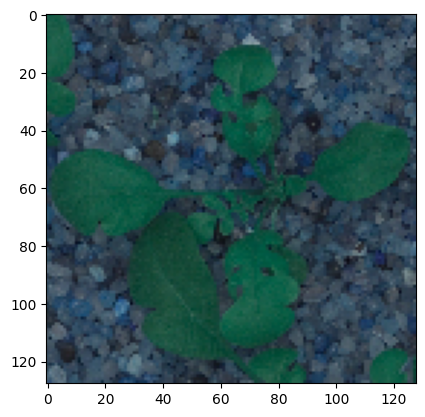

In [15]:
#Show a single sample image
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(images_copy[1000])

#### Observations
* We can observe that the images are being shown in BGR when plotted with openCV.  We will need to convert to RGB for better viewing and recognition

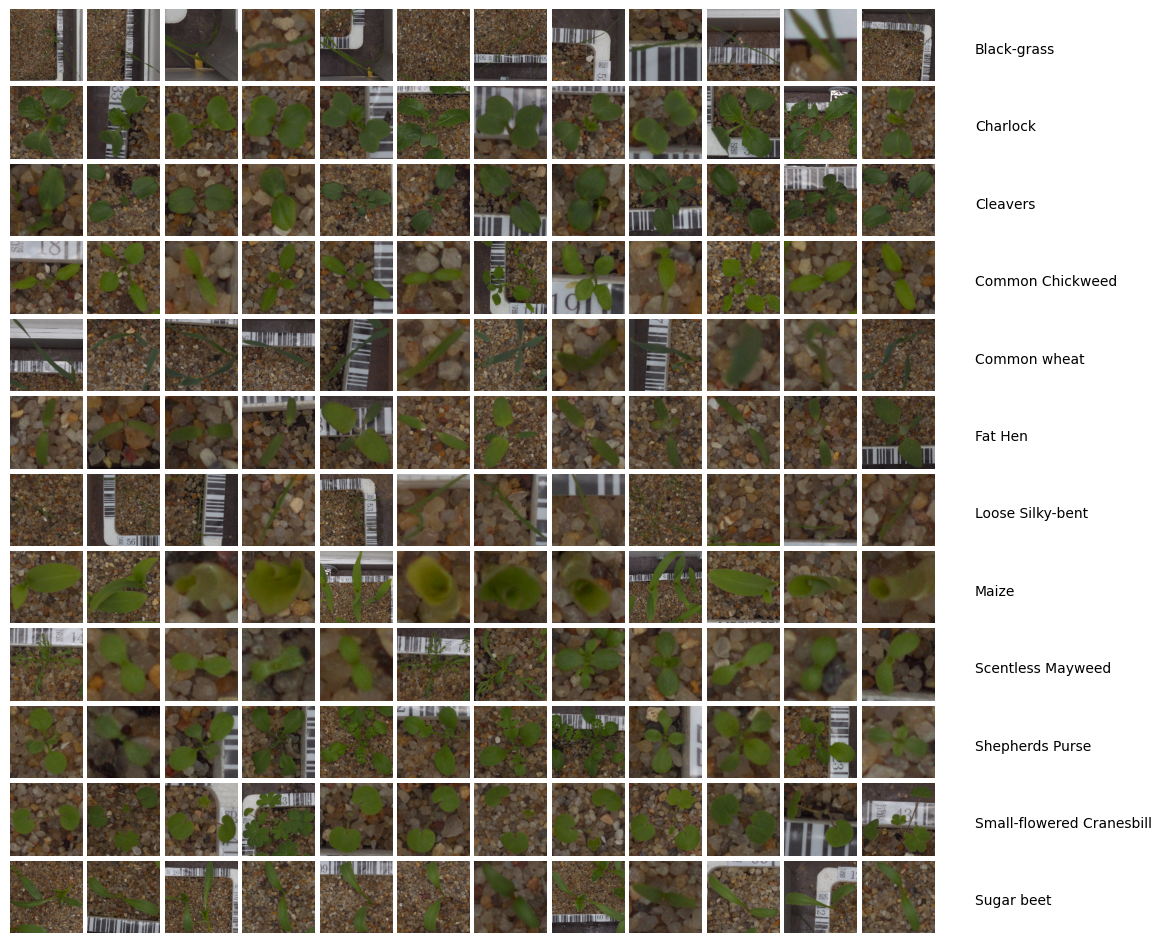

In [16]:
#Show sample images
#defining a grid of size 12X12
fig = plt.figure(1, figsize=(num_labels, num_labels))
grid = ImageGrid(fig, 111, nrows_ncols=(num_labels, num_labels), axes_pad=0.05)
i = 0
index = labels.index

# 12 images from each category
for category_id, category in enumerate(labels_plants):
  condition = labels["Label"] == category
  plant_indices = index[condition].tolist()
  for j in range(0,num_labels):
      ax = grid[i]
      image_rgb = cv2.cvtColor(images_copy[plant_indices[j]], cv2.COLOR_BGR2RGB)                      # Adding subplots with 3 rows and 4 columns
      ax.imshow(image_rgb)
      ax.axis('off')
      if i % num_labels == num_labels - 1:
        #print the names for each category
        ax.text(200, 70, category, verticalalignment='center')
      i += 1
plt.show();

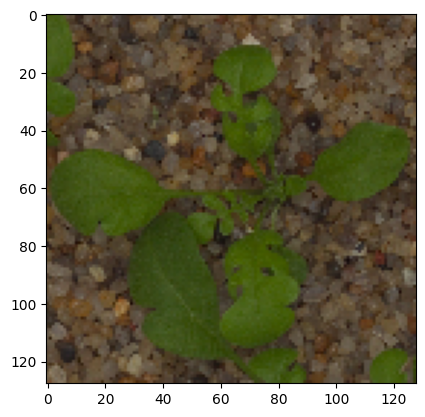

In [17]:
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(cv2.cvtColor(images_copy[1000], cv2.COLOR_BGR2RGB))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Loose Silky-bent'),
  Text(1, 0, 'Common Chickweed'),
  Text(2, 0, 'Scentless Mayweed'),
  Text(3, 0, 'Small-flowered Cranesbill'),
  Text(4, 0, 'Fat Hen'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Sugar beet'),
  Text(7, 0, 'Cleavers'),
  Text(8, 0, 'Black-grass'),
  Text(9, 0, 'Shepherds Purse'),
  Text(10, 0, 'Common wheat'),
  Text(11, 0, 'Maize')])

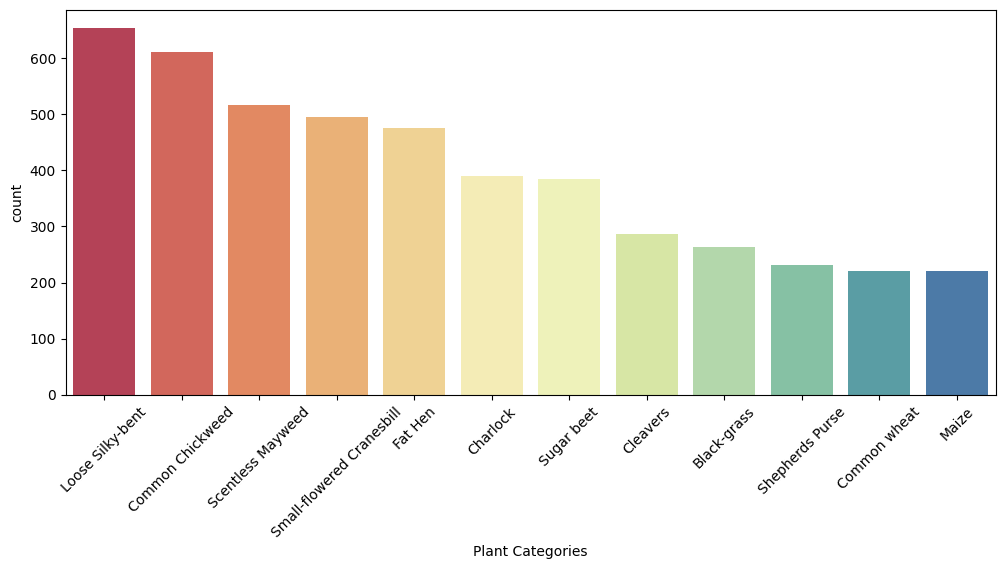

In [18]:
plt.rcParams["figure.figsize"] = (12,5)
sns.countplot(x=labels.iloc[:,-1],order = labels['Label'].value_counts().index, palette='Spectral')
plt.xlabel('Plant Categories')
plt.xticks(rotation=45)

#### Observations:
* This data set is imbalanced
* "Loose Silky-bent" plant images are the largest group, followed by "Common Chickweed" and "Scentless Mayweed"
* The smallest image groupings are "Sheperds Purse", "Common Wheat" and "Maize"

## Data Pre-Processing

In [19]:
# switch paths to have a processed files
images_to_process = images_copy.copy() #leaving in place in case I decide to look at lap
images_to_resize = images_copy.copy()

### Convert and/or resize the images based on flags set earlier

In [20]:
images_to_resize.shape

(4750, 128, 128, 3)

As we can see, the images are currently 128 x 128 x 3

In [21]:
# Resizing the image size to half ie., from 128X128 to 64X64 and converting to RGB
images_color_resized=[]
for i in range(len(images_to_resize)):
    
    #Apply sharpen filter
    if SHARPEN:
        kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
        images_to_resize[i] = cv2.filter2D(src=images_to_resize[i], ddepth=-1, kernel=kernel)
    
    #Apply Gaussian blur
    if BLUR:
        images_to_resize[i] = cv2.GaussianBlur(images_to_resize[i],(5,5),0)

    #Convert the BGR images to RGB images
    images_to_resize[i] = cv2.cvtColor(images_to_resize[i], cv2.COLOR_BGR2RGB) 
    
    #Resize images
    if RESIZE:
        images_color_resized.append( cv2.resize(images_to_resize[i], None, fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)) 
    else:
        images_color_resized.append( cv2.resize(images_to_resize[i], None, fx=1.0, fy=1.0, interpolation=cv2.INTER_LINEAR))

In [22]:
np.shape(images_color_resized)

(4750, 64, 64, 3)

##### Observations
* We can see the images are now 64x64 in size.
* They retain the color channels.

**Image before resizing**



Image before resizing


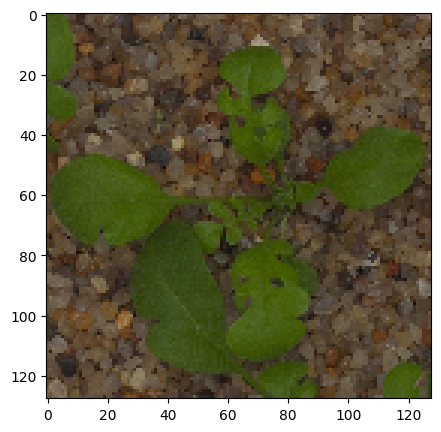

In [23]:
    
print('\n')
print("Image before resizing")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(cv2.cvtColor(images_copy[1000], cv2.COLOR_BGR2RGB))

#### Observations
This image is pretty blurry already, suggesting it was resized once already. Resizing again may cause it to lose more data, affecting accuracy.

Image resized with no sharpening



Image resized with no sharpening/blurring


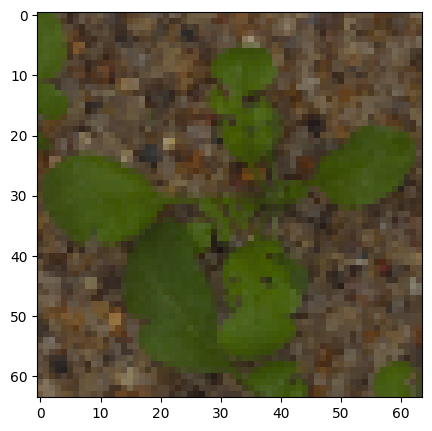

In [24]:
image_resize = cv2.resize(images_copy[1000], None, fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)

print('\n')
print("Image resized with no sharpening/blurring")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))

#### Observations
After resizing, this image becomes much less distinctive, suggesting resizing may affect accuracy.

Image after sharpening before resizing



Original image after sharpening


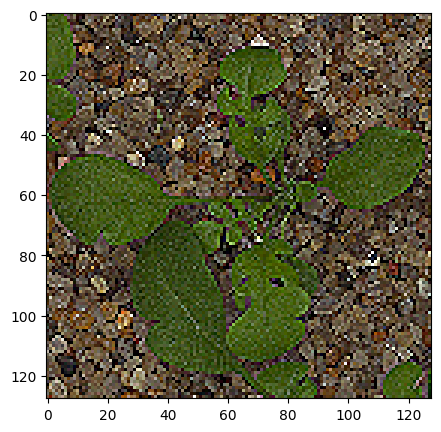

In [25]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=images_copy[1000], ddepth=-1, kernel=kernel)

print('\n')
print("Original image after sharpening")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(cv2.cvtColor(image_sharp, cv2.COLOR_BGR2RGB))


#### Observations
Sharpening this image makes the edges appear a bit more distinctive and may help in identifying the plant.



Original image after blurring


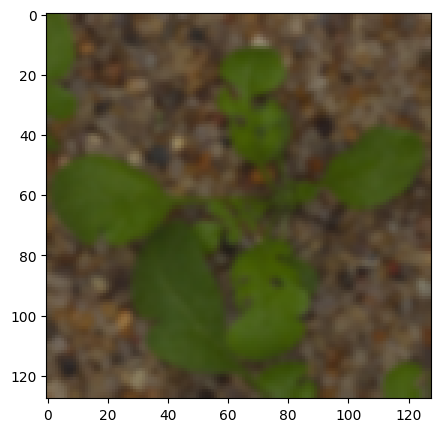

In [26]:
image_blur = cv2.GaussianBlur(images_copy[1000],(5,5),0)

print('\n')
print("Original image after blurring")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(images_copy[1000])
else:
    plt.imshow(cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB))

#### Observations
Blurring this image makes the edges much softer. This may not lead to good identification accuracy.

**Image after resizing**



Original image after sharpening/resizing


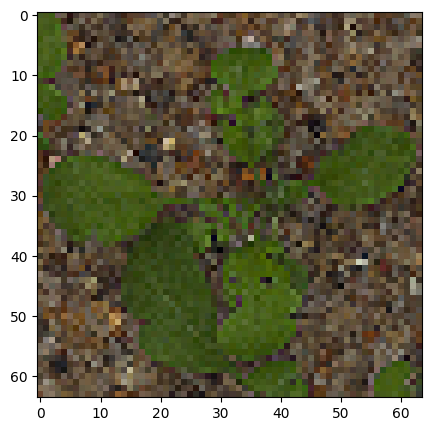

In [27]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=images_copy[1000], ddepth=-1, kernel=kernel)
image_sharp_resize = cv2.resize(image_sharp, None, fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)

print('\n')
print("Original image after sharpening/resizing")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(image_sharp_resize)
else:
    plt.imshow(cv2.cvtColor(image_sharp_resize, cv2.COLOR_BGR2RGB))

#### Observations
This image becomes much less distinctive once resized, even with sharpening.



Original image after blurring/resizing


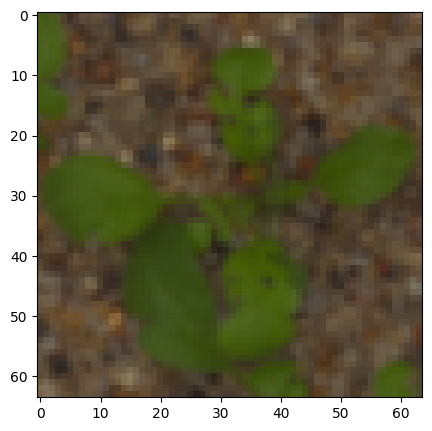

In [28]:
image_blur = cv2.GaussianBlur(images_copy[1000],(5,5),0)
image_blur_resize = cv2.resize(image_blur, None, fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)

print('\n')
print("Original image after blurring/resizing")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(image_blur_resize)
else:
    plt.imshow(cv2.cvtColor(image_blur_resize, cv2.COLOR_BGR2RGB))

#### Observations
After blurring and resizing, this image become much softer at the edges.

### Data Preparation for Modeling


- As we do not have many images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We will split the dataset into three parts, train,test and validation.

In [29]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_color_resized),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [30]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encoding the target labels

In [31]:
# Convert labels from names to one hot vectors.

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [32]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape 

((3847, 12), (428, 12), (475, 12))

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**



Image before normalization


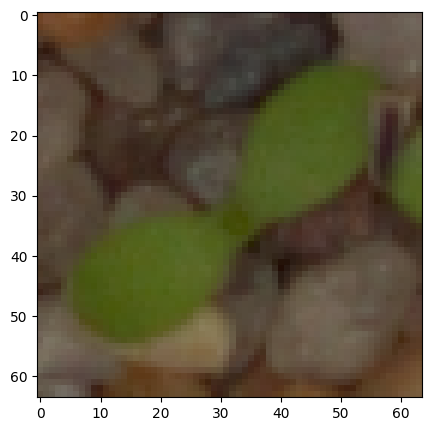

In [33]:
print('\n')
print("Image before normalization")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(X_train[1])
else:
    plt.imshow(X_train[1])

In [34]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0



Image after normalization


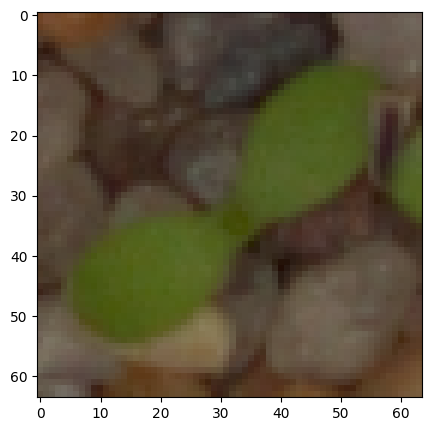

In [35]:
print('\n')
print("Image after normalization")
if IN_COLAB:
    print("Running in Colab")
    cv2_imshow(X_train_normalized[1])
else:
    plt.imshow(X_train_normalized[1])

#### Observations
* Image appears unchanged after normalization

## Model Building

Store model results in a dataframe for later comparison.

In [36]:
training_metrics = pd.DataFrame(columns=["accuracy"])
test_metrics = pd.DataFrame(columns=["accuracy"])

### Build first model (basic) containing multiple layers for image processing and dense layer for classification

#### CNN Model layers:

* Convolutional input layer, 128 feature maps with a size of 3X3 and a * rectifier activation function
* Max Pool layer with size 2×2 and a stride of 2
* Convolutional layer, 64 feature maps with a size of 3X3 and a rectifier activation function.
* Max Pool layer with size 2×2 and a stride of 2
* Convolutional layer, 32 feature maps with a size of 3X3 and a rectifier activation function.
* Max Pool layer with size 2×2 and a stride of 2
* Flatten layer
* Fully connected or Dense layers (with 16 neurons) with Relu Act.
* Dropout layer to reduce overfitting or for regularization
* Output layer with Softmax to detect multiple categories (12).

In [37]:
# Clearing backend
backend.clear_session()

In [38]:
model_name = "Base Model"

In [39]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [40]:
# verify image sizes for input layer
np.shape(X_train_normalized)

(3847, 64, 64, 3)

In [41]:
# Since I will be trying various combos of resizing set the input layer dynamically
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
base_model = Sequential()

# create convolution and max-pooling layers with input size of images
base_model.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(h, w, c)))
base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
base_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
base_model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
base_model.add(Flatten())

# add a fully connected layer
base_model.add(Dense(16, activation='relu'))
base_model.add(Dropout(0.3))
# output layer with 12 neurons and softmax
base_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
base_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
base_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (Max

<b> Fitting the model on the train data

In [42]:
base_history = base_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2
)

Epoch 1/50
61/61 - 9s - loss: 2.4596 - accuracy: 0.1003 - val_loss: 2.4518 - val_accuracy: 0.1379 - 9s/epoch - 146ms/step
Epoch 2/50
61/61 - 8s - loss: 2.4410 - accuracy: 0.1198 - val_loss: 2.4196 - val_accuracy: 0.1472 - 8s/epoch - 124ms/step
Epoch 3/50
61/61 - 8s - loss: 2.3448 - accuracy: 0.2028 - val_loss: 2.1197 - val_accuracy: 0.3458 - 8s/epoch - 133ms/step
Epoch 4/50
61/61 - 9s - loss: 2.1166 - accuracy: 0.3002 - val_loss: 1.9292 - val_accuracy: 0.3762 - 9s/epoch - 140ms/step
Epoch 5/50
61/61 - 9s - loss: 1.9635 - accuracy: 0.3273 - val_loss: 1.8374 - val_accuracy: 0.3949 - 9s/epoch - 147ms/step
Epoch 6/50
61/61 - 9s - loss: 1.8773 - accuracy: 0.3481 - val_loss: 1.6673 - val_accuracy: 0.4486 - 9s/epoch - 151ms/step
Epoch 7/50
61/61 - 9s - loss: 1.7978 - accuracy: 0.3587 - val_loss: 1.6041 - val_accuracy: 0.4813 - 9s/epoch - 152ms/step
Epoch 8/50
61/61 - 9s - loss: 1.6865 - accuracy: 0.3962 - val_loss: 1.5025 - val_accuracy: 0.5280 - 9s/epoch - 150ms/step
Epoch 9/50
61/61 - 10s -

**Model Evaluation**

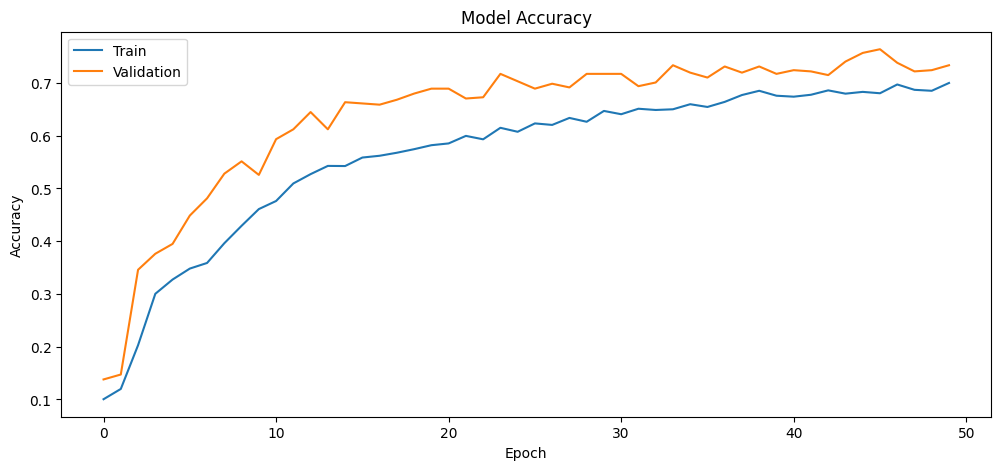

In [43]:
plt.plot(base_history.history['accuracy'])
plt.plot(base_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* Fom the graph we can see that the training accuracy of the model was reached the 70% range and the validation accuracy was divergent and eventually reached the 60% range.
* It does not seem to improve much past epoch 25.

**Loss**

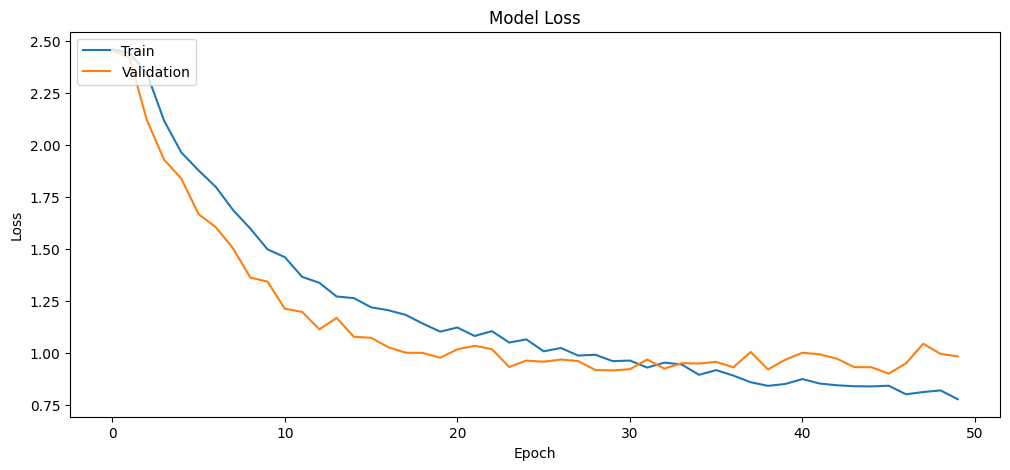

In [44]:
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss between Training and validation swaps around epoch 34. 
* It does not seem to improve much past epoch 35.

**Evaluate the model on test data**

In [45]:
base_history_accuracy = base_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 0s 27ms/step - loss: 0.9205 - accuracy: 0.7326


In [46]:
best_model_accuracy = base_history.history['accuracy'][np.argmin(base_history.history['loss'])]
best_model_accuracy

0.7000259757041931

In [47]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = base_history_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.700026
Name: Base Model, dtype: float64
accuracy    0.732632
Name: Base Model, dtype: float64


**Plotting the Confusion Matrix**

In [48]:
# Here we would get the output as probablities for each category
y_pred=base_model.predict(X_test_normalized)

15/15 [==============================] - 0s 28ms/step


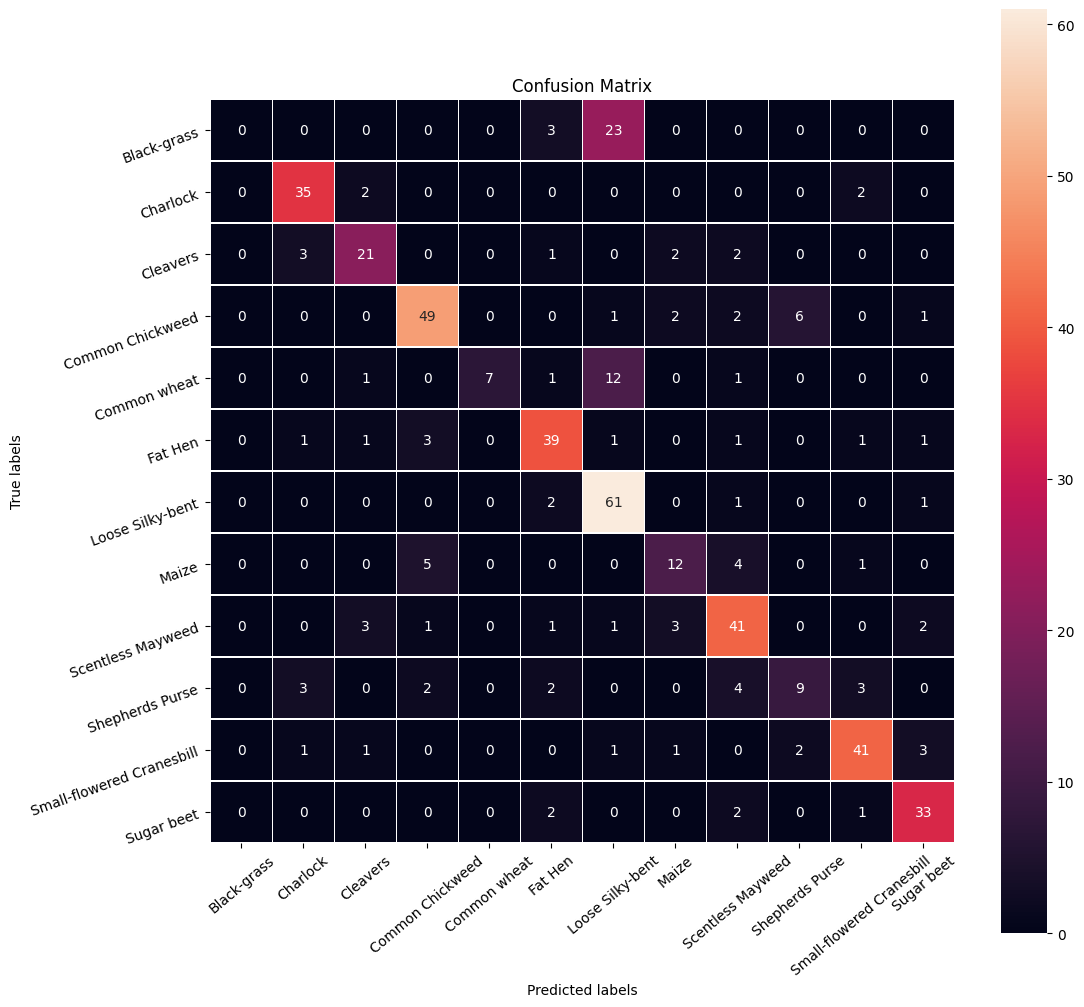

In [49]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations

* We can observe that some of the plant classes are not predicted correctly.
* It appears none of the Black-grass samples were correctly identified (23, 3).
* We can also observe that Black-grass(26), Common Chickweed(12), Common Wheat(15), Maize(10), Scentless Mayweed(11), Sheperds Purse(10) and Fat Hen(9) have the largest misclassifications.

### Complex CNN model containing multiple layers for image processing and dense layer for classification

Here we will add complexity to the model to try and get better results.

#### CNN Model layers:

* Convolutional input layer, 32 feature maps with a size of 3X3 and a * rectifier activation function
* Max Pool layer with size 2×2 and a stride of 2
* Convolutional layer, 64 feature maps with a size of 3X3 and a rectifier activation function.
* Max Pool layer with size 2×2 and a stride of 2
* Convolutional layer, 128 feature maps with a size of 3X3 and a rectifier activation function.
* Max Pool layer with size 2×2 and a stride of 2
* Convolutional layer, 128 feature maps with a size of 3X3 and a rectifier activation function.
* Max Pool layer with size 2×2 and a stride of 2
* Flatten layer
* Fully connected or Dense layers (with 128 neurons) with Relu Act.
* Dropout layer to reduce overfitting or for regularization
* Fully connected or Dense layers (with 512 neurons) with Relu Act.
* Dropout layer to reduce overfitting or for regularization
* Fully connected or Dense layers (with 256 neurons) with Relu Act.
* Dropout layer to reduce overfitting or for regularization
* Output layer with Softmax to detect multiple categories (12).

In [50]:
# Clearing backend
backend.clear_session()

In [51]:
model_name = "Complex Model"

In [52]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [53]:
# verify image sizes for input layer
np.shape(X_train_normalized)

(3847, 64, 64, 3)

In [54]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
complex_model = Sequential()

# create convolution and max-pooling layers with input size of images
complex_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h, w, c)))
complex_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
complex_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
complex_model.add(Flatten())

# add a fully connected layer
complex_model.add(Dense(128, activation='relu'))
complex_model.add(Dropout(0.3))

# add a fully connected layer
complex_model.add(Dense(512, activation='relu'))
complex_model.add(Dropout(0.3))

# add a fully connected layer
complex_model.add(Dense(256, activation='relu'))
complex_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
complex_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
complex_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
complex_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (Max

<b> Fitting the model on the train data

In [55]:
complex_history = complex_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2
)

Epoch 1/50
61/61 - 7s - loss: 2.4347 - accuracy: 0.1318 - val_loss: 2.4040 - val_accuracy: 0.1379 - 7s/epoch - 113ms/step
Epoch 2/50
61/61 - 5s - loss: 2.3157 - accuracy: 0.1994 - val_loss: 1.9667 - val_accuracy: 0.2757 - 5s/epoch - 89ms/step
Epoch 3/50
61/61 - 6s - loss: 1.8033 - accuracy: 0.3384 - val_loss: 1.5833 - val_accuracy: 0.4299 - 6s/epoch - 93ms/step
Epoch 4/50
61/61 - 5s - loss: 1.5718 - accuracy: 0.4359 - val_loss: 1.4064 - val_accuracy: 0.4813 - 5s/epoch - 89ms/step
Epoch 5/50
61/61 - 6s - loss: 1.3404 - accuracy: 0.5269 - val_loss: 1.3290 - val_accuracy: 0.5444 - 6s/epoch - 98ms/step
Epoch 6/50
61/61 - 6s - loss: 1.2357 - accuracy: 0.5719 - val_loss: 1.1874 - val_accuracy: 0.6145 - 6s/epoch - 99ms/step
Epoch 7/50
61/61 - 6s - loss: 1.0727 - accuracy: 0.6192 - val_loss: 1.0276 - val_accuracy: 0.6402 - 6s/epoch - 96ms/step
Epoch 8/50
61/61 - 6s - loss: 1.0283 - accuracy: 0.6371 - val_loss: 1.0235 - val_accuracy: 0.6495 - 6s/epoch - 97ms/step
Epoch 9/50
61/61 - 6s - loss: 0

**Model Evaluation**

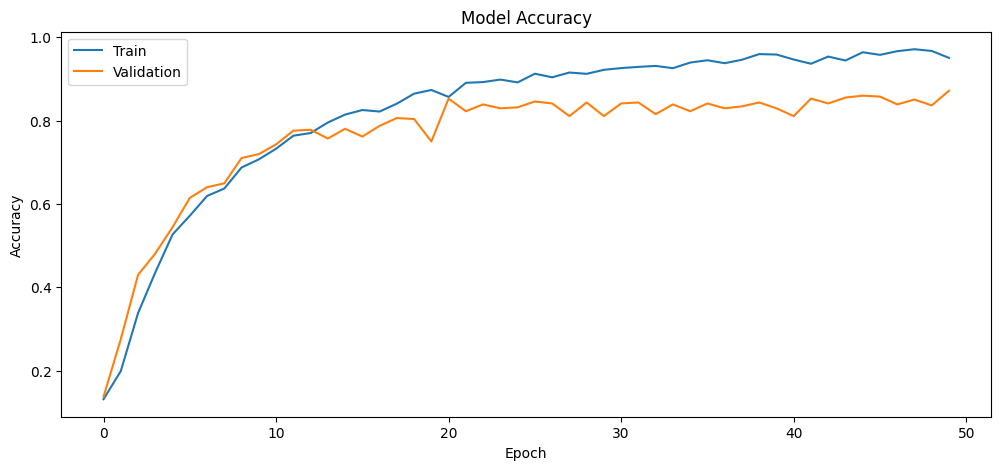

In [56]:
plt.plot(complex_history.history['accuracy'])
plt.plot(complex_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* Fom the graph we can see that the training accuracy of the model was improved over the base model and the validation accuracy was also improved.
* The model seems to overfit on the training data.
* It does not seem to improve much past epoch 25.  We will use 25 as our base epochs.

**Loss**

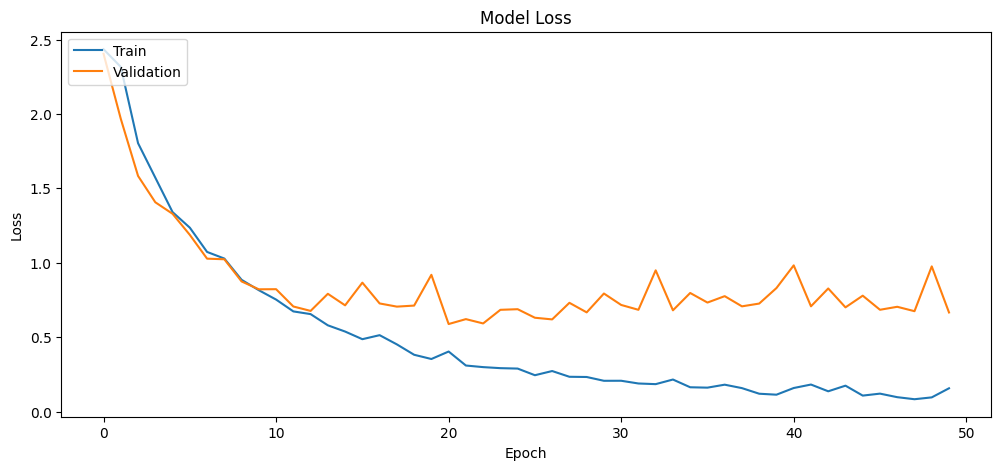

In [57]:
plt.plot(complex_history.history['loss'])
plt.plot(complex_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss between Training and validation diverges around epoch 12. 
* Validation loss holds fairly constant.
* It does not seem to improve much past epoch 25.

**Evaluate the model on test data**

In [58]:
complex_history_accuracy = complex_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 38ms/step - loss: 0.7007 - accuracy: 0.8211


In [59]:
best_model_accuracy = complex_history.history['accuracy'][np.argmin(complex_history.history['loss'])]
best_model_accuracy

0.9711463451385498

In [60]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = complex_history_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.971146
Name: Complex Model, dtype: float64
accuracy    0.821053
Name: Complex Model, dtype: float64


#### Observations
* Test Accuracy is 82%
* Training model accuracy with least loss is 97%, showing overfitting.

**Plotting the Confusion Matrix**

In [61]:
# Here we would get the output as probablities for each category
y_pred=complex_model.predict(X_test_normalized)

15/15 [==============================] - 1s 39ms/step


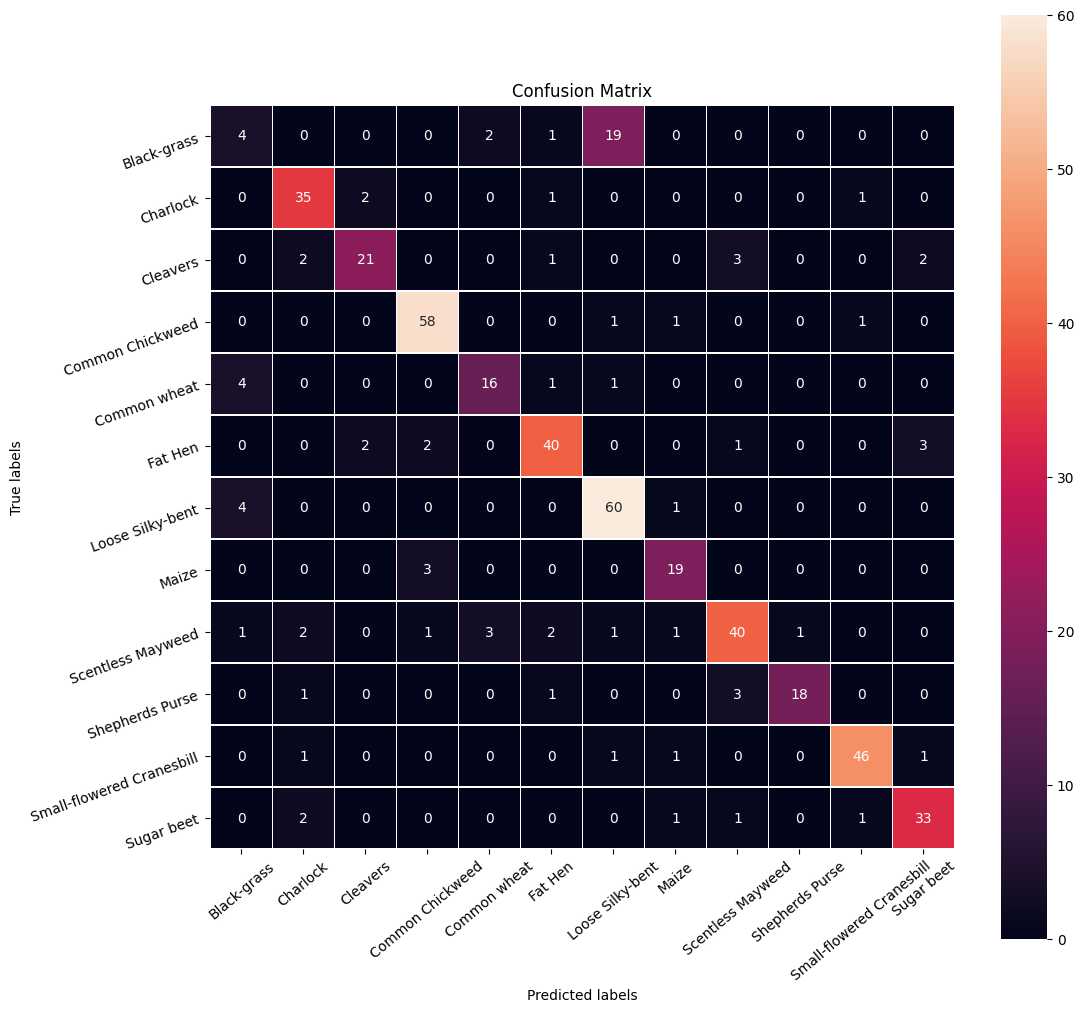

In [62]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations

* We can observe that some of the plant classes are still not predicted correctly.
* It appears that we now have some of the Black-grass samples correctly identified.
* Common Chickweed has dropped from 12 misidentified to 3.
* Common Wheat has dropped from 15 misidentified to 6.
* Fat Hen has dropped from 9 misidentified to 8.
* Maize has dropped from 10 misidentified to 3.
* Sheperds Purse has dropped from 10 misidentified to 5.
* Scentless Mayweed has increased from 11 misidentified to 12.
* Loose Silky-bent remains 5, but it is now misidentified differently.
* Black-grass(22), Common Wheat and Scentless Mayweed have the largest misclassifications.

## Model Performance Improvement

#### Applying Class weights to complex model

In [63]:
from sklearn.utils import class_weight

labelList = np.unique(labels)
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 1.5050860719874803,
 1: 1.0145042194092826,
 2: 1.3818247126436782,
 3: 0.6476430976430977,
 4: 1.7909683426443204,
 5: 0.8348524305555556,
 6: 0.604874213836478,
 7: 1.7909683426443204,
 8: 0.7669457735247209,
 9: 1.714349376114082,
 10: 0.7974709784411277,
 11: 1.0275106837606838}

In [64]:
# Clearing backend
backend.clear_session()

In [65]:
model_name = "Complex Model with Class Weights applied"

In [66]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [67]:
# verify image sizes for input layer
np.shape(X_train_normalized)

(3847, 64, 64, 3)

In [68]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
complex_model_class_weights = Sequential()

# create convolution and max-pooling layers with input size of images
complex_model_class_weights.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h, w, c)))
complex_model_class_weights.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_class_weights.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
complex_model_class_weights.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_class_weights.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model_class_weights.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_class_weights.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model_class_weights.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
complex_model_class_weights.add(Flatten())

# add a fully connected layer
complex_model_class_weights.add(Dense(128, activation='relu'))
complex_model_class_weights.add(Dropout(0.3))

# add a fully connected layer
complex_model_class_weights.add(Dense(512, activation='relu'))
complex_model_class_weights.add(Dropout(0.3))

# add a fully connected layer
complex_model_class_weights.add(Dense(256, activation='relu'))
complex_model_class_weights.add(Dropout(0.3))

# output layer with 12 neurons and softmax
complex_model_class_weights.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
complex_model_class_weights.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
complex_model_class_weights.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (Max

<b> Fitting the model on the train data

In [69]:
complex_class_weights_history = complex_model_class_weights.fit(
            X_train_normalized, y_train_encoded,
            class_weight=class_weights,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2
)

Epoch 1/50
61/61 - 8s - loss: 2.4733 - accuracy: 0.0894 - val_loss: 2.4177 - val_accuracy: 0.1215 - 8s/epoch - 132ms/step
Epoch 2/50
61/61 - 6s - loss: 2.1632 - accuracy: 0.1734 - val_loss: 1.9372 - val_accuracy: 0.2383 - 6s/epoch - 100ms/step
Epoch 3/50
61/61 - 6s - loss: 1.8823 - accuracy: 0.2727 - val_loss: 1.7028 - val_accuracy: 0.2664 - 6s/epoch - 101ms/step
Epoch 4/50
61/61 - 6s - loss: 1.7305 - accuracy: 0.3140 - val_loss: 1.7540 - val_accuracy: 0.3271 - 6s/epoch - 102ms/step
Epoch 5/50
61/61 - 6s - loss: 1.7018 - accuracy: 0.3267 - val_loss: 1.5707 - val_accuracy: 0.3949 - 6s/epoch - 99ms/step
Epoch 6/50
61/61 - 6s - loss: 1.5672 - accuracy: 0.3800 - val_loss: 1.5150 - val_accuracy: 0.4346 - 6s/epoch - 98ms/step
Epoch 7/50
61/61 - 6s - loss: 1.5019 - accuracy: 0.4079 - val_loss: 1.3537 - val_accuracy: 0.5070 - 6s/epoch - 97ms/step
Epoch 8/50
61/61 - 6s - loss: 1.4124 - accuracy: 0.4713 - val_loss: 1.2559 - val_accuracy: 0.5678 - 6s/epoch - 97ms/step
Epoch 9/50
61/61 - 6s - loss

**Model Evaluation**

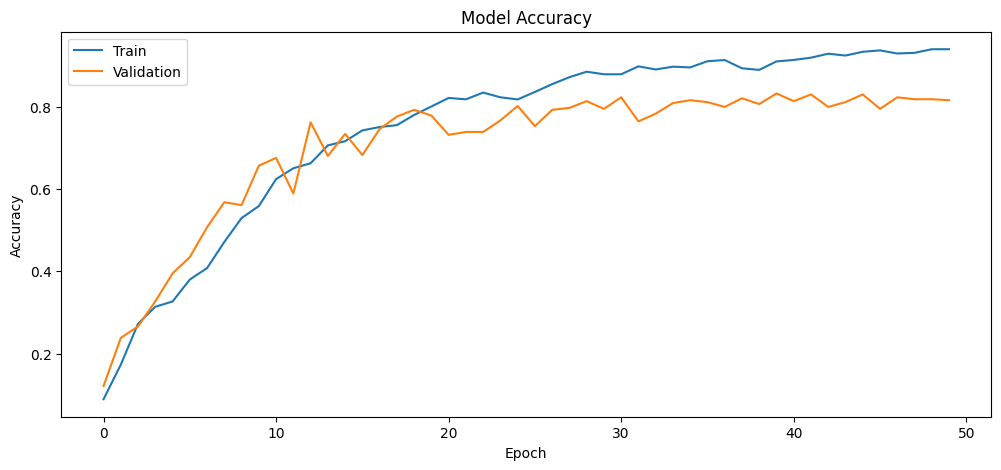

In [70]:
plt.plot(complex_class_weights_history.history['accuracy'])
plt.plot(complex_class_weights_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* Fom the graph we can see that the training accuracy of the model was improved over the base model and the validation accuracy was also improved.
* The model seems to overfit on the training data.
* It does not seem to improve much past epoch 25.  We will use 25 as our base epochs.

**Loss**

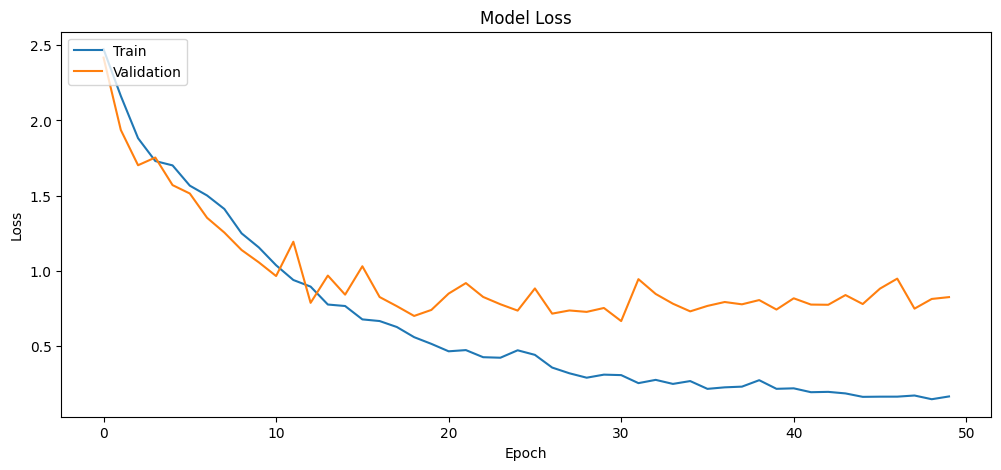

In [71]:
plt.plot(complex_class_weights_history.history['loss'])
plt.plot(complex_class_weights_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss between Training and validation diverges around epoch 12. 
* Validation loss holds fairly constant.
* It does not seem to improve much past epoch 25.

**Evaluate the model on test data**

In [72]:
complex_class_weights_history_accuracy = complex_model_class_weights.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 39ms/step - loss: 0.8297 - accuracy: 0.7958


In [73]:
best_model_accuracy = complex_class_weights_history.history['accuracy'][np.argmin(complex_class_weights_history.history['loss'])]
best_model_accuracy

0.9391734004020691

In [74]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = complex_class_weights_history_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.939173
Name: Complex Model with Class Weights applied, dtype: float64
accuracy    0.795789
Name: Complex Model with Class Weights applied, dtype: float64


#### Observations
* Test Accuracy is 80%
* Training model accuracy with least loss is 94%.
* Adjusting the class weights did not improve identification.

**Plotting the Confusion Matrix**

In [75]:
# Here we would get the output as probablities for each category
y_pred=complex_model.predict(X_test_normalized)

15/15 [==============================] - 1s 40ms/step


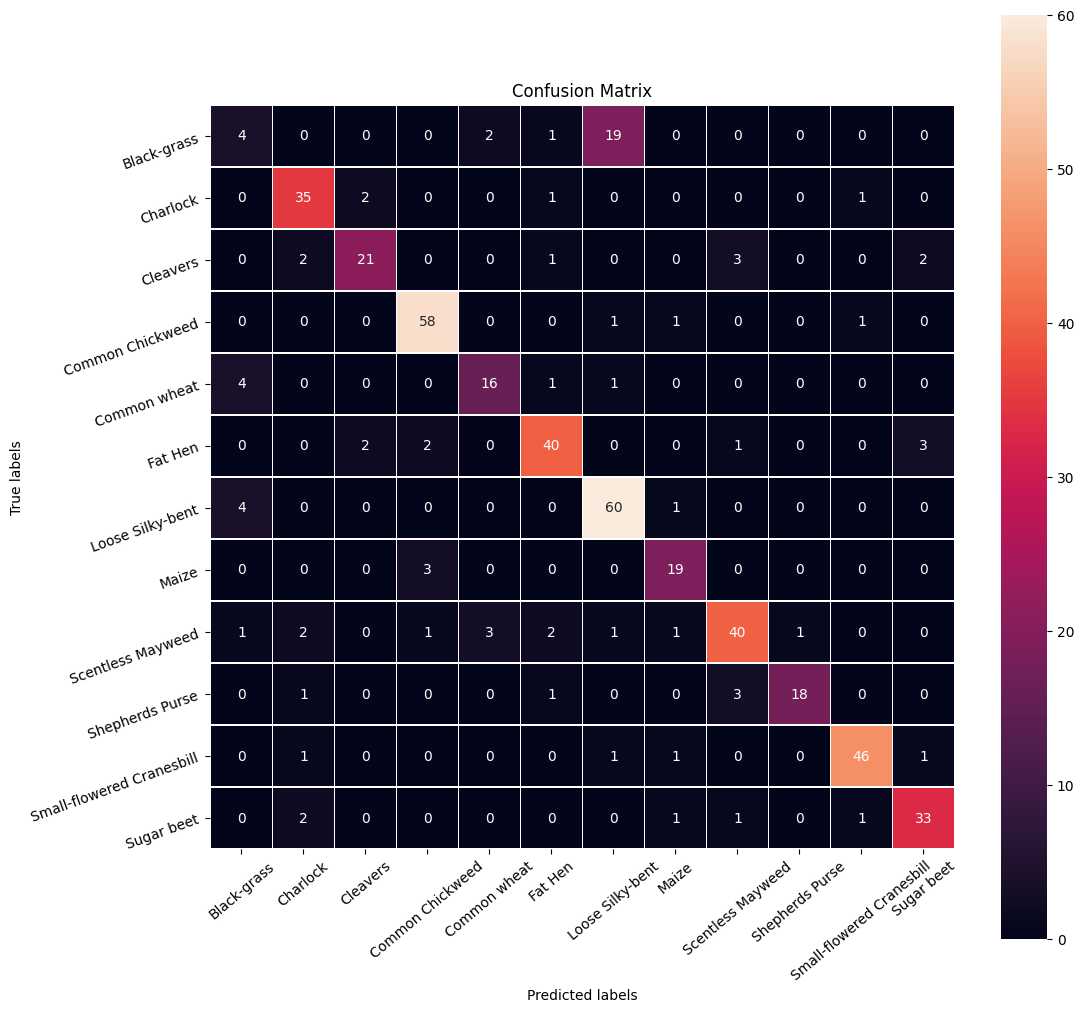

In [76]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* The misidentified plants did not improve much, if at all. We will try another strategy.

### Model using adjustment of the Adam optimizer:

In this model we will not use Class weights.  We will adjust the adam optimizer using learning rate, decay rate and avoiding division by zero. 


In [77]:
# Clearing backend
backend.clear_session()

In [78]:
model_name = "Complex Model with Adam optimizer adjusted"

In [79]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [80]:
# verify image sizes for input layer
np.shape(X_train_normalized)

(3847, 64, 64, 3)

In [81]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
complex_model_adam_opt = Sequential()

# create convolution and max-pooling layers with input size of images
complex_model_adam_opt.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h, w, c)))
complex_model_adam_opt.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_adam_opt.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
complex_model_adam_opt.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_adam_opt.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model_adam_opt.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
complex_model_adam_opt.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
complex_model_adam_opt.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
complex_model_adam_opt.add(Flatten())

# add a fully connected layer
complex_model_adam_opt.add(Dense(128, activation='relu'))
complex_model_adam_opt.add(Dropout(0.3))

# add a fully connected layer
complex_model_adam_opt.add(Dense(512, activation='relu'))
complex_model_adam_opt.add(Dropout(0.3))

# add a fully connected layer
complex_model_adam_opt.add(Dense(256, activation='relu'))
complex_model_adam_opt.add(Dropout(0.3))

# output layer with 12 neurons and softmax
complex_model_adam_opt.add(Dense(12, activation='softmax'))

# Adam Optimizer
adam_opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile the model
complex_model_adam_opt.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
complex_model_adam_opt.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (Max

<b> Fitting the model on the train data

In [82]:
complex_adam_opt_history = complex_model_adam_opt.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2
)

Epoch 1/50
61/61 - 7s - loss: 2.4335 - accuracy: 0.1300 - val_loss: 2.4119 - val_accuracy: 0.1379 - 7s/epoch - 123ms/step
Epoch 2/50
61/61 - 6s - loss: 2.4147 - accuracy: 0.1300 - val_loss: 2.4252 - val_accuracy: 0.1285 - 6s/epoch - 105ms/step
Epoch 3/50
61/61 - 6s - loss: 2.4214 - accuracy: 0.1398 - val_loss: 2.4081 - val_accuracy: 0.1379 - 6s/epoch - 100ms/step
Epoch 4/50
61/61 - 6s - loss: 2.3789 - accuracy: 0.1521 - val_loss: 2.3051 - val_accuracy: 0.1612 - 6s/epoch - 104ms/step
Epoch 5/50
61/61 - 6s - loss: 2.1494 - accuracy: 0.2313 - val_loss: 1.9198 - val_accuracy: 0.3551 - 6s/epoch - 106ms/step
Epoch 6/50
61/61 - 6s - loss: 1.7694 - accuracy: 0.3543 - val_loss: 1.5920 - val_accuracy: 0.4229 - 6s/epoch - 103ms/step
Epoch 7/50
61/61 - 6s - loss: 1.5474 - accuracy: 0.4474 - val_loss: 1.4632 - val_accuracy: 0.5117 - 6s/epoch - 101ms/step
Epoch 8/50
61/61 - 7s - loss: 1.3990 - accuracy: 0.5069 - val_loss: 1.1936 - val_accuracy: 0.5888 - 7s/epoch - 107ms/step
Epoch 9/50
61/61 - 7s - 

**Model Evaluation**

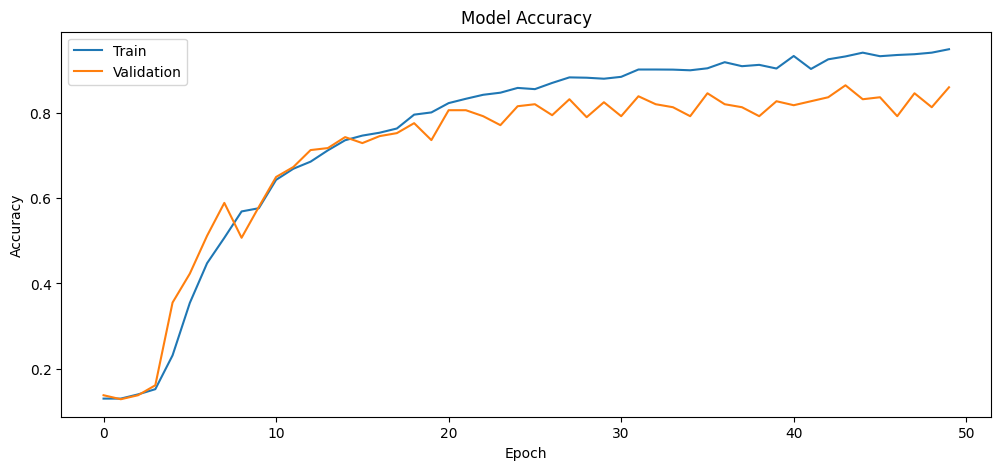

In [83]:
plt.plot(complex_adam_opt_history.history['accuracy'])
plt.plot(complex_adam_opt_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* This model behaves much like the non adjusted adam optimizer model.
* It does not seem to improve much past epoch 25.

**Loss**

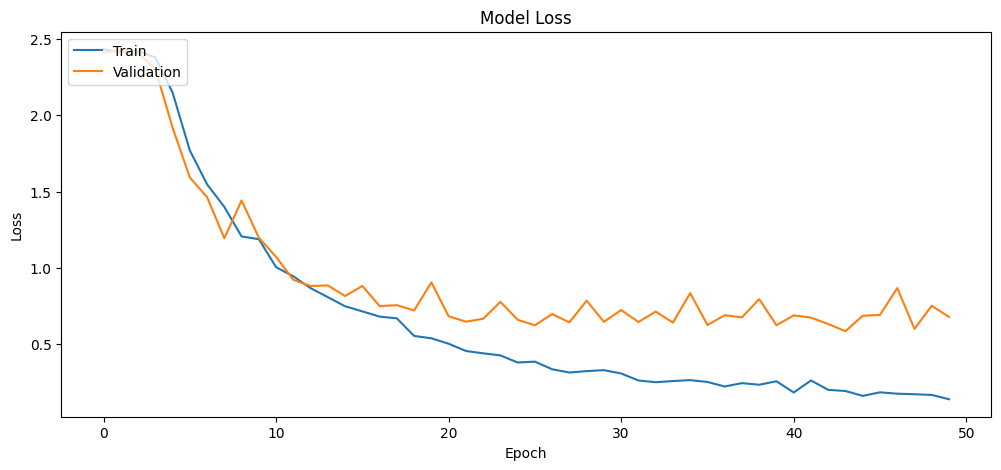

In [84]:
plt.plot(complex_adam_opt_history.history['loss'])
plt.plot(complex_adam_opt_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Again similar performance as the non adjusted adam model.
* It does not seem to improve much past epoch 35.

**Evaluate the model on test data**

In [85]:
complex_history_adam_opt_accuracy = complex_model_adam_opt.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 41ms/step - loss: 0.6181 - accuracy: 0.8400


In [86]:
best_model_accuracy = complex_adam_opt_history.history['accuracy'][np.argmin(complex_adam_opt_history.history['loss'])]
best_model_accuracy

0.9490512013435364

In [87]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = complex_history_adam_opt_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.949051
Name: Complex Model with Adam optimizer adjusted, dtype: float64
accuracy    0.84
Name: Complex Model with Adam optimizer adjusted, dtype: float64


#### Observations
* Test Accuracy is 84%
* Training model accuracy with least loss is 95% so a bit of overfitting there.

**Plotting the Confusion Matrix**

In [88]:
# Here we would get the output as probablities for each category
y_pred=complex_model_adam_opt.predict(X_test_normalized)

15/15 [==============================] - 1s 38ms/step


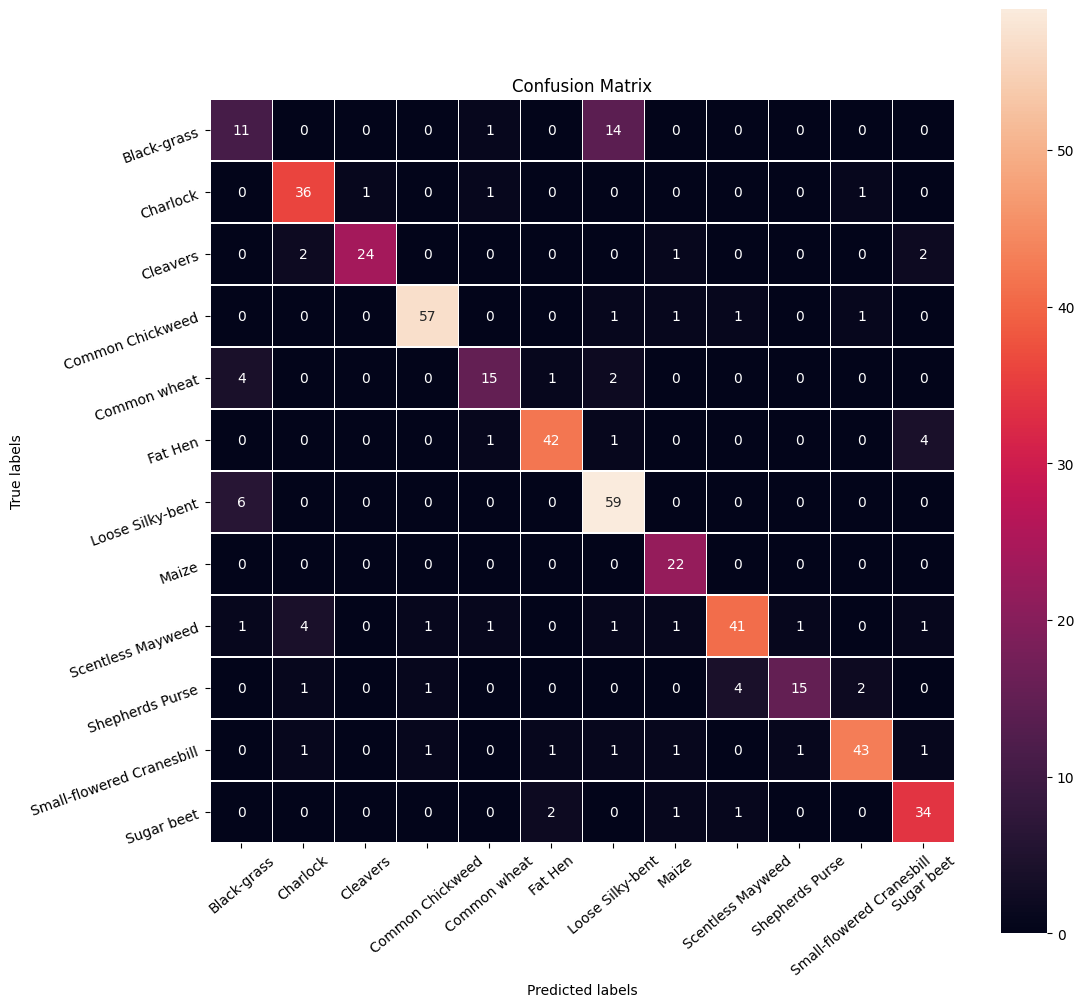

In [89]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Common Chickweed, Sheperds Purse, and Common Wheat did not improve from base complex model.
* Fat Hen has improved a bit from 8 misidentified to 6.
* Loose Silky-bent and Maize have been 100% identified correctly.
* Scentless Mayweed returned to 11 misidentified from 12.
* Black-grass(14) remains the largest misclassification.

### Model adjusted by reducing the Learning Rate:

In this model we will use the ReduceLRonPlateau to adjust the model. We will also add Batch Normalization.

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [90]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2, #was 3
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [91]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [92]:
model_name = "Complex Model with learning rate reduction and batch normalization"

In [93]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
lron_base_model = Sequential()

# create convolution and max-pooling layers with input size of images
lron_base_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h,w,c)))
lron_base_model.add(BatchNormalization())
lron_base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_base_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
lron_base_model.add(BatchNormalization())
lron_base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_base_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_base_model.add(BatchNormalization())
lron_base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_base_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_base_model.add(BatchNormalization())
lron_base_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
lron_base_model.add(Flatten())

# add a fully connected layer
lron_base_model.add(Dense(128, activation='relu'))
lron_base_model.add(Dropout(0.3))

# add a fully connected layer
lron_base_model.add(Dense(512, activation='relu'))
lron_base_model.add(Dropout(0.3))

# add a fully connected layer
lron_base_model.add(Dense(256, activation='relu'))
lron_base_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
lron_base_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
lron_base_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
lron_base_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                     

<b> Fitting the model on the train data

In [94]:
lron_base_history = lron_base_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=epochs,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=2,callbacks=[learning_rate_reduction])

Epoch 1/25
121/121 - 19s - loss: 2.0012 - accuracy: 0.3312 - val_loss: 7.4617 - val_accuracy: 0.1379 - lr: 0.0010 - 19s/epoch - 156ms/step
Epoch 2/25
121/121 - 17s - loss: 1.3346 - accuracy: 0.5545 - val_loss: 13.4252 - val_accuracy: 0.1379 - lr: 0.0010 - 17s/epoch - 139ms/step
Epoch 3/25
121/121 - 16s - loss: 1.0517 - accuracy: 0.6460 - val_loss: 4.0732 - val_accuracy: 0.1869 - lr: 0.0010 - 16s/epoch - 136ms/step
Epoch 4/25
121/121 - 17s - loss: 0.8448 - accuracy: 0.7174 - val_loss: 13.2370 - val_accuracy: 0.1379 - lr: 0.0010 - 17s/epoch - 138ms/step
Epoch 5/25
121/121 - 17s - loss: 0.7431 - accuracy: 0.7515 - val_loss: 3.0628 - val_accuracy: 0.3925 - lr: 0.0010 - 17s/epoch - 139ms/step
Epoch 6/25
121/121 - 16s - loss: 0.6106 - accuracy: 0.7915 - val_loss: 1.8700 - val_accuracy: 0.4883 - lr: 0.0010 - 16s/epoch - 133ms/step
Epoch 7/25
121/121 - 15s - loss: 0.5493 - accuracy: 0.8121 - val_loss: 0.8549 - val_accuracy: 0.7687 - lr: 0.0010 - 15s/epoch - 128ms/step
Epoch 8/25
121/121 - 16s 

**Model Evaluation**

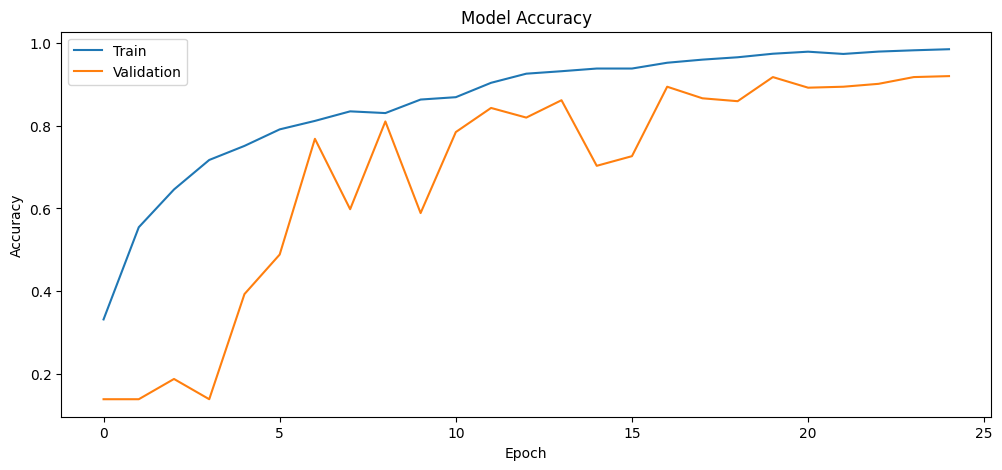

In [95]:
plt.plot(lron_base_history.history['accuracy'])
plt.plot(lron_base_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* Fom the graph we can see that the training accuracy of the model was reaching overfitting.
* The validation accuracy was oscillating and divergent.

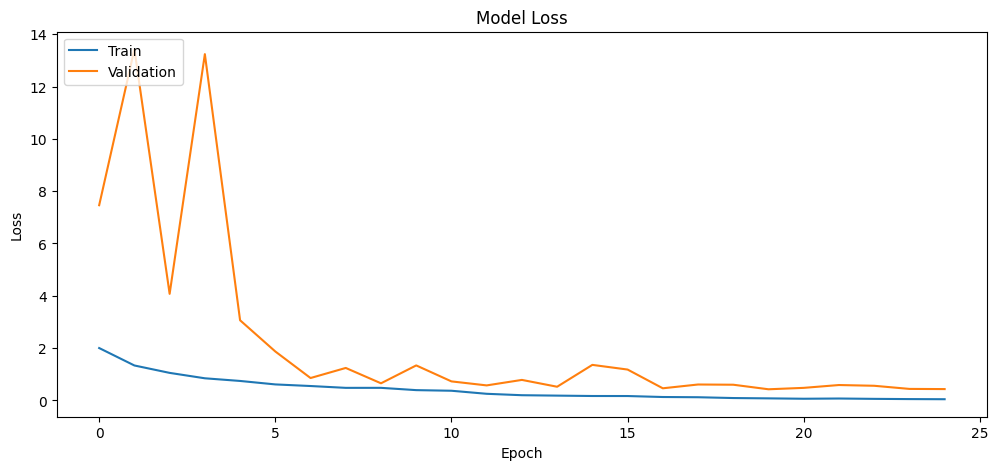

In [96]:
plt.plot(lron_base_history.history['loss'])
plt.plot(lron_base_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations
* Loss between Training and validation remains pretty stable after epoch 13.

**Evaluate the model on test data**

In [97]:
lron_base_model_test_accuracy = lron_base_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 62ms/step - loss: 0.4490 - accuracy: 0.9116


In [98]:
best_model_accuracy = lron_base_history.history['accuracy'][np.argmin(lron_base_history.history['loss'])]
best_model_accuracy

0.98570317029953

In [99]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = lron_base_model_test_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.985703
Name: Complex Model with learning rate reduction and batch normalization, dtype: float64
accuracy    0.911579
Name: Complex Model with learning rate reduction and batch normalization, dtype: float64


#### Observations
* Test Accuracy is 91%
* Training model accuracy with least loss is 99%.

**Plotting the Confusion Matrix**

In [100]:
# Complete the code to obtain the output probabilities
y_pred=lron_base_model.predict(X_test_normalized)

15/15 [==============================] - 1s 61ms/step


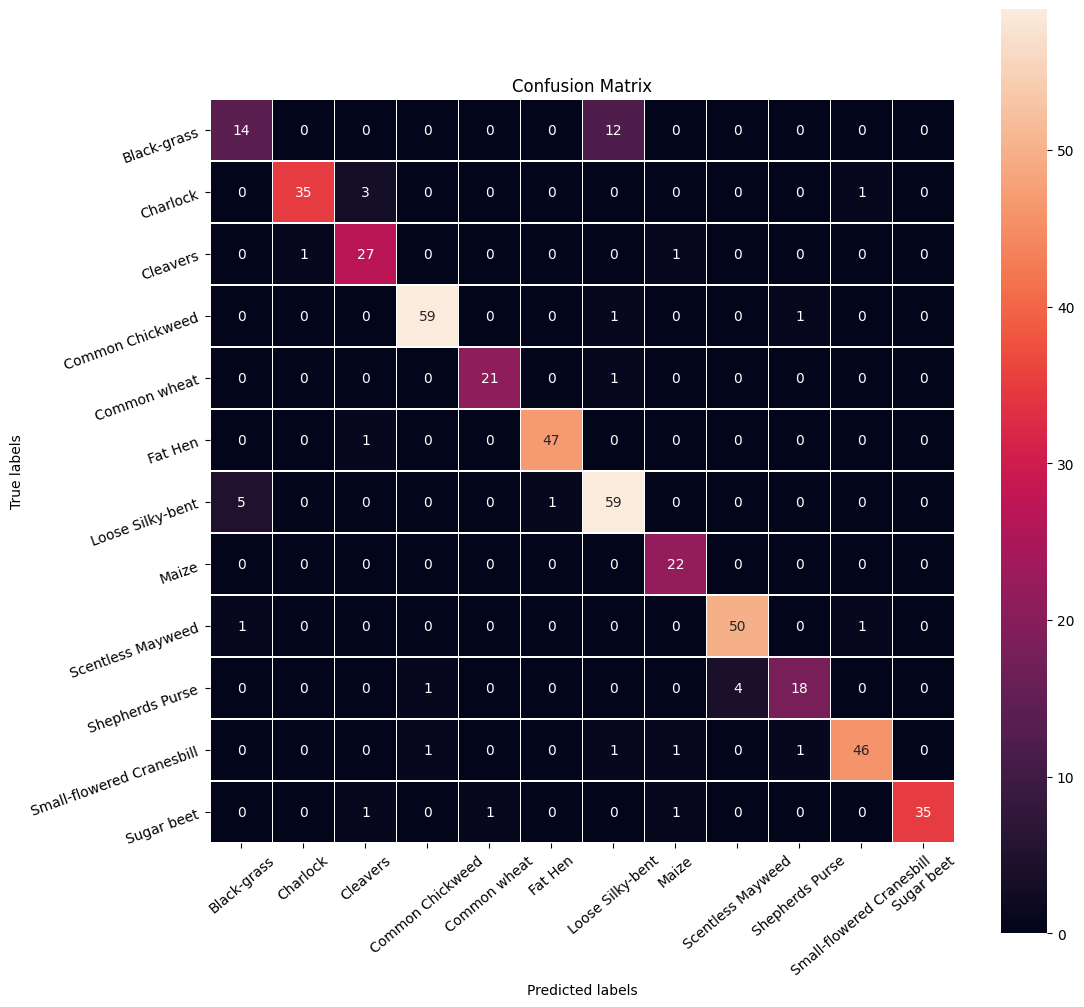

In [101]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Black-grass has improved from 14 to 12 misindentified
* Common Chickweed, Common Wheat, Fat Hen, Scentless Mayweed have all improved.
* Maize has been 100% identified correctly.
* Sheperds Purse has increased in misidentification.
* Loose Silky-bent is still highly misclassified.

### Model with basic Data Augmentation

In this model we will add basic data augmentation techniques and keep the batch normalization and learning rate reduction.


In [102]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [103]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [104]:
model_name = "Complex Model with batch normalization, learning rate reduction and basic data augmentation"

In [105]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
lron_da_model = Sequential()

# create convolution and max-pooling layers with input size of images
lron_da_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h,w,c)))
lron_da_model.add(BatchNormalization())
lron_da_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
lron_da_model.add(BatchNormalization())
lron_da_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da_model.add(BatchNormalization())
lron_da_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da_model.add(BatchNormalization())
lron_da_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
lron_da_model.add(Flatten())

# add a fully connected layer
lron_da_model.add(Dense(128, activation='relu'))
lron_da_model.add(Dropout(0.3))

# add a fully connected layer
lron_da_model.add(Dense(512, activation='relu'))
lron_da_model.add(Dropout(0.3))

# add a fully connected layer
lron_da_model.add(Dense(256, activation='relu'))
lron_da_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
lron_da_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
lron_da_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
lron_da_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                     

<b> Fitting the model on the train data

In [106]:
lron_da_history = lron_da_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=32,
                                       shuffle=False),
                                       epochs=epochs,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,
                                       callbacks=[learning_rate_reduction])

Epoch 1/25
121/121 [==============================] - 19s 146ms/step - loss: 2.0073 - accuracy: 0.3174 - val_loss: 8.4350 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/25
121/121 [==============================] - 19s 154ms/step - loss: 1.3775 - accuracy: 0.5217 - val_loss: 15.4300 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 3/25
121/121 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.6291
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
121/121 [==============================] - 19s 154ms/step - loss: 1.1028 - accuracy: 0.6291 - val_loss: 15.1994 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 4/25
121/121 [==============================] - 18s 152ms/step - loss: 0.8084 - accuracy: 0.7255 - val_loss: 10.1189 - val_accuracy: 0.1379 - lr: 5.0000e-04
Epoch 5/25
121/121 [==============================] - 19s 153ms/step - loss: 0.6915 - accuracy: 0.7635 - val_loss: 2.3219 - val_accuracy: 0.4463 - lr: 5.0000e-04
Epoch 6/25
121/121 [==================

**Model Evaluation**

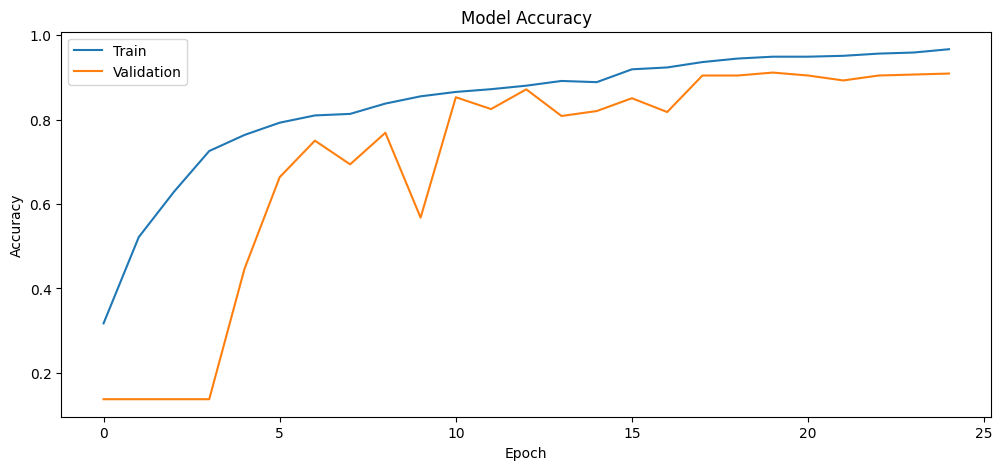

In [107]:
plt.plot(lron_da_history.history['accuracy'])
plt.plot(lron_da_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations

* We still see signs of the training data overfitting and oscillations of the validation data until around epoch 16.
* Training and validation are still pretty divergent.

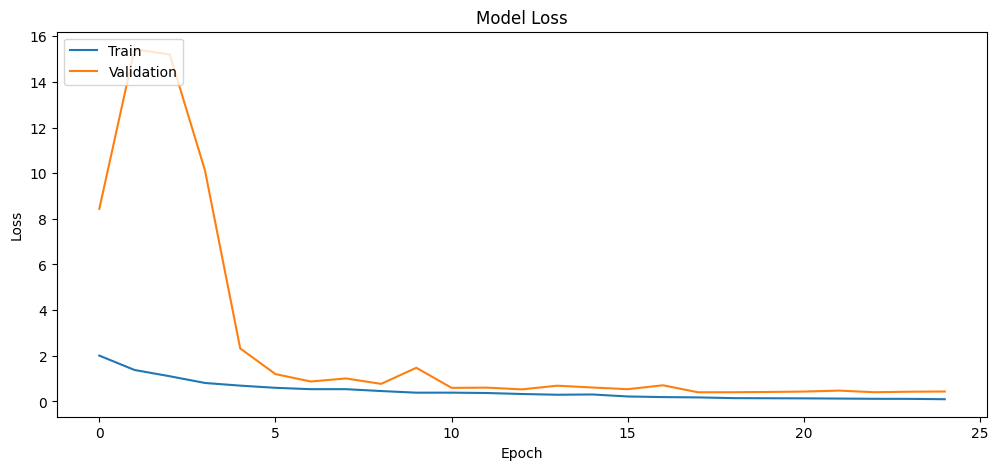

In [108]:
plt.plot(lron_da_history.history['loss'])
plt.plot(lron_da_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss flattens out beyond epoch 10.

**Evaluate the model on test data**

In [109]:
lron_da_test_accuracy = lron_da_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 66ms/step - loss: 0.4274 - accuracy: 0.8947


In [110]:
best_model_accuracy = lron_da_history.history['accuracy'][np.argmin(lron_da_history.history['loss'])]
best_model_accuracy

0.9664673805236816

In [111]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = lron_da_test_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.966467
Name: Complex Model with batch normalization, learning rate reduction and basic data augmentation, dtype: float64
accuracy    0.894737
Name: Complex Model with batch normalization, learning rate reduction and basic data augmentation, dtype: float64


#### Observations
* Test Accuracy is 89%, so a slight improvement
* Model accuracy with least loss is 97%, so overfitting a bit less.

**Plotting the Confusion Matrix**

In [112]:
# Complete the code to obtain the output probabilities
y_pred=lron_da_model.predict(X_test_normalized)

15/15 [==============================] - 1s 63ms/step


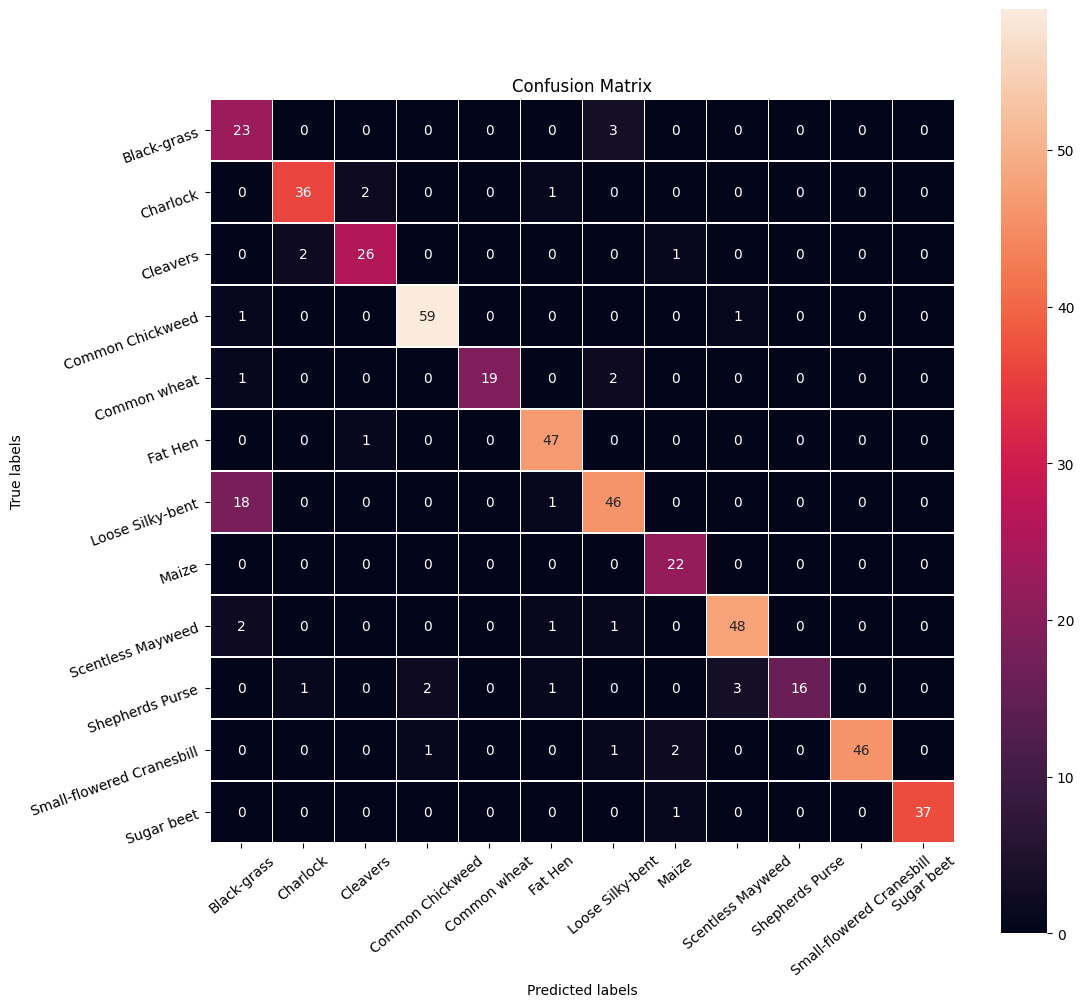

In [113]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Black-grass has improved from 8 to 3 misindentified
* Common Chickweed, Common Wheat, Fat Hen, Scentless Mayweed have all remained a low percentage of misidentifications.
* Maize has been 100% identified correctly.
* Sheperds Purse has increased by 1 in misidentification.
* Loose Silky-bent is now the largest misclassification.
* Most others remain about the same level of misclassification.

#### Model adjustment by adding steps per epoch

We will add steps per epoch to set how many times we get a new batch from the generator to try and improve the model.  This will end up discarding 7 images in training.  This will work in conjunction with ReduceLROnPlateau to better decrease the learning rate.

In [114]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [115]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [116]:
model_name = "Complex Model with batch normalization, learning rate reduction, basic data augmentation and steps per epoch"

In [117]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
lron_da_spe_model = Sequential()

# create convolution and max-pooling layers with input size of images
lron_da_spe_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h,w,c)))
lron_da_spe_model.add(BatchNormalization())
lron_da_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_spe_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
lron_da_spe_model.add(BatchNormalization())
lron_da_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_spe_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da_spe_model.add(BatchNormalization())
lron_da_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da_spe_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da_spe_model.add(BatchNormalization())
lron_da_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
lron_da_spe_model.add(Flatten())

# add a fully connected layer
lron_da_spe_model.add(Dense(128, activation='relu'))
lron_da_spe_model.add(Dropout(0.3))

# add a fully connected layer
lron_da_spe_model.add(Dense(512, activation='relu'))
lron_da_spe_model.add(Dropout(0.3))

# add a fully connected layer
lron_da_spe_model.add(Dense(256, activation='relu'))
lron_da_spe_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
lron_da_spe_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()
# Compile the model
lron_da_spe_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
lron_da_spe_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                     

<b> Fitting the model on the train data

In [118]:
lron_da_spe_history = lron_da_spe_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size, #errors out of range
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/25
120/120 [==============================] - 20s 151ms/step - loss: 2.0092 - accuracy: 0.3166 - val_loss: 8.3740 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/25
120/120 [==============================] - 19s 155ms/step - loss: 1.3914 - accuracy: 0.5266 - val_loss: 11.3857 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.6275
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
120/120 [==============================] - 19s 157ms/step - loss: 1.1237 - accuracy: 0.6275 - val_loss: 15.8686 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 4/25
120/120 [==============================] - 19s 162ms/step - loss: 0.8396 - accuracy: 0.7132 - val_loss: 6.4671 - val_accuracy: 0.1565 - lr: 5.0000e-04
Epoch 5/25
120/120 [==============================] - 19s 162ms/step - loss: 0.6952 - accuracy: 0.7507 - val_loss: 2.5973 - val_accuracy: 0.3879 - lr: 5.0000e-04
Epoch 6/25
120/120 [===================

**Model Evaluation**

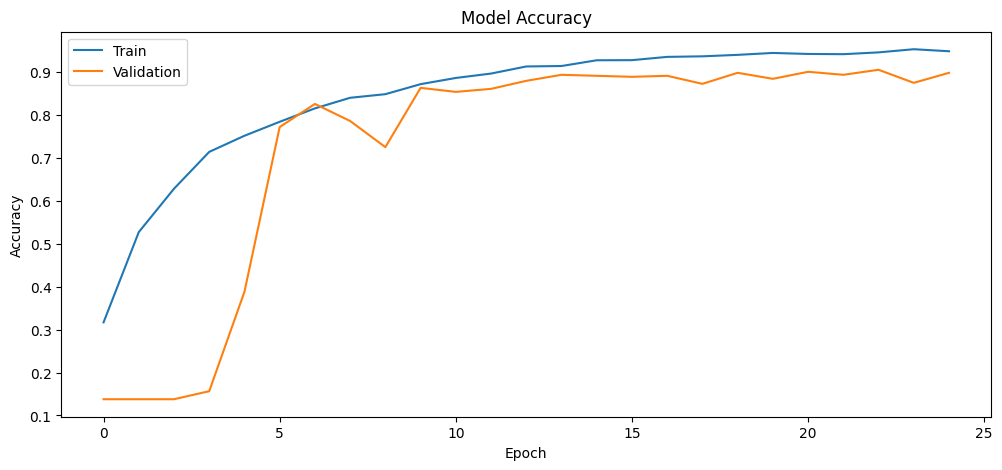

In [119]:
plt.plot(lron_da_spe_history.history['accuracy'])
plt.plot(lron_da_spe_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations
* We still see signs of the training data overfitting though the validation data is much closer.
* Training and validation are still pretty divergent.

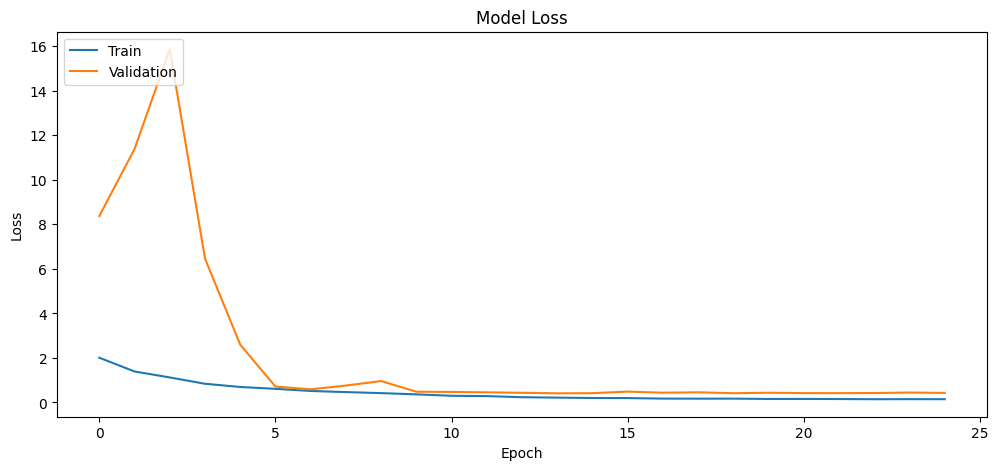

In [120]:
plt.plot(lron_da_spe_history.history['loss'])
plt.plot(lron_da_spe_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations
* Loss flattens around epoch 5.

**Evaluate the model on test data**

In [121]:
lron_da_spe_test_accuracy = lron_da_spe_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 65ms/step - loss: 0.4318 - accuracy: 0.8968


In [122]:
best_model_accuracy = lron_da_spe_history.history['accuracy'][np.argmin(lron_da_spe_history.history['loss'])]
best_model_accuracy

0.9446920156478882

In [123]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = lron_da_spe_test_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.944692
Name: Complex Model with batch normalization, learning rate reduction, basic data augmentation and steps per epoch, dtype: float64
accuracy    0.896842
Name: Complex Model with batch normalization, learning rate reduction, basic data augmentation and steps per epoch, dtype: float64


#### Observations
* Test Accuracy is 90%
* Training model accuracy with least loss is 95%

**Plotting the Confusion Matrix**

In [124]:
# Complete the code to obtain the output probabilities
y_pred=lron_da_spe_model.predict(X_test_normalized)

15/15 [==============================] - 1s 66ms/step


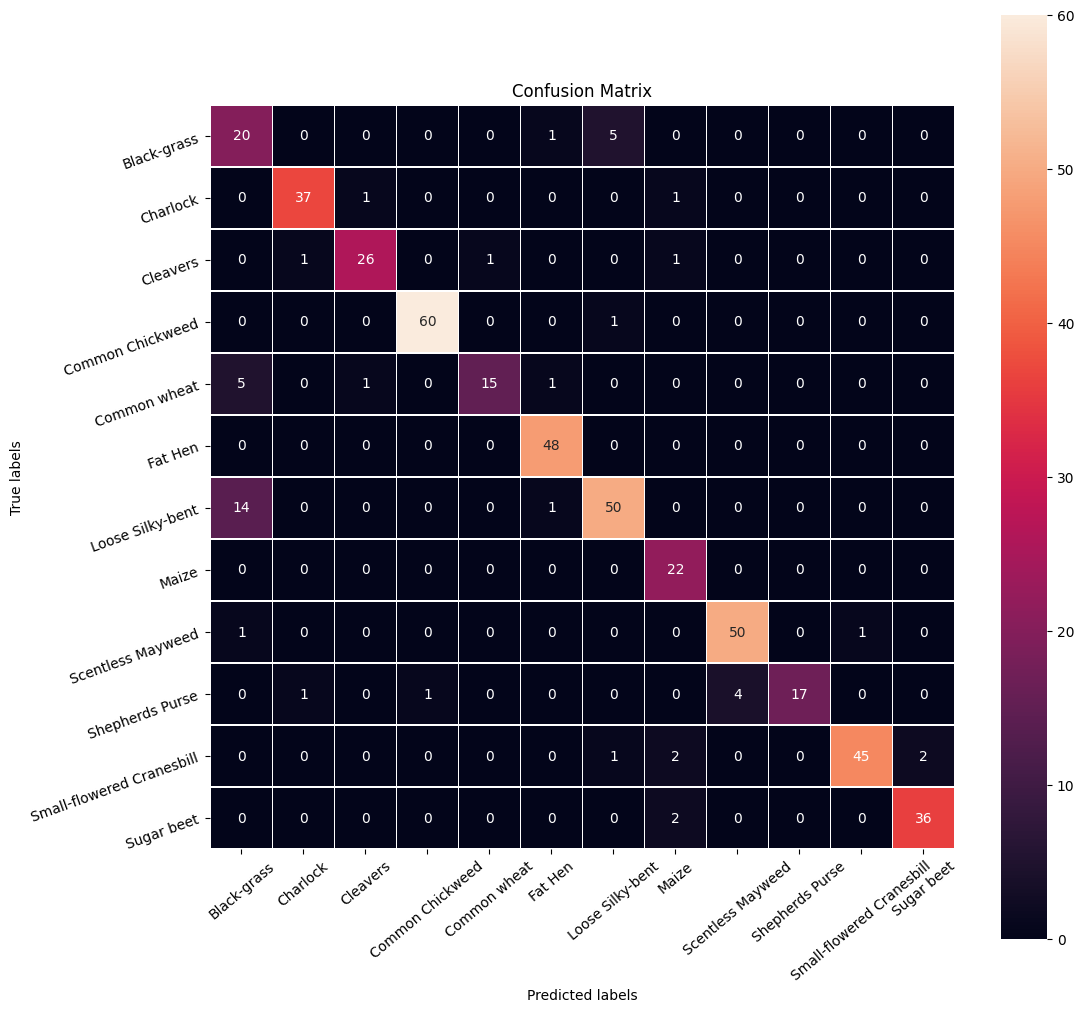

In [125]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Misclassification of Black-grass has worsened
* Misclassification of Loose Silky-bent has improved
* Most others remain about the same level of misclassification.

#### Increase the epochs and add early stopping to limit learning
In this model we will increase the epochs to try and improve learning, but limit it using the early stopping callback to prevent too many epochs from running.

In [126]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [127]:
model_name = "Complex Model with batch normalization, learning rate reduction, basic data augmentation, steps per epoch and early stopping"

In [128]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [129]:
early_stopping__callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, restore_best_weights=True)

In [130]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
lron_da2_spe_es_model = Sequential()

# create convolution and max-pooling layers with input size of images
lron_da2_spe_es_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h,w,c)))
lron_da2_spe_es_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da2_spe_es_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
lron_da2_spe_es_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da2_spe_es_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da2_spe_es_model.add(MaxPooling2D((2, 2), padding = 'same'))

# add BatchNormalization
lron_da2_spe_es_model.add(BatchNormalization())

# create convolution and max-pooling layers
lron_da2_spe_es_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da2_spe_es_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
lron_da2_spe_es_model.add(Flatten())

# add a fully connected layer
lron_da2_spe_es_model.add(Dense(128, activation='relu'))
lron_da2_spe_es_model.add(Dropout(0.3))

# add a fully connected layer
lron_da2_spe_es_model.add(Dense(512, activation='relu'))
lron_da2_spe_es_model.add(Dropout(0.3))

# add a fully connected layer
lron_da2_spe_es_model.add(Dense(256, activation='relu'))
lron_da2_spe_es_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
lron_da2_spe_es_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
lron_da2_spe_es_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
lron_da2_spe_es_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (Max

<b> Fitting the model on the train data

In [131]:
lron_da2_spe_es_history = lron_da2_spe_es_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=100,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size, #errors out of range
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,
                                       callbacks=[learning_rate_reduction,early_stopping__callback])

Epoch 1/100
120/120 [==============================] - 14s 105ms/step - loss: 2.0579 - accuracy: 0.2734 - val_loss: 2.4149 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 12s 97ms/step - loss: 1.4825 - accuracy: 0.4747 - val_loss: 2.2907 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 12s 97ms/step - loss: 1.3135 - accuracy: 0.5389 - val_loss: 1.8938 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 12s 98ms/step - loss: 1.1223 - accuracy: 0.6068 - val_loss: 1.5954 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 12s 98ms/step - loss: 0.9872 - accuracy: 0.6569 - val_loss: 1.2421 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 11s 95ms/step - loss: 0.9010 - accuracy: 0.6865 - val_loss: 0.7893 - val_accuracy: 0.7570 - lr: 0.0010
Epoch 7/100
120/120 [==============================

**Model Evaluation**

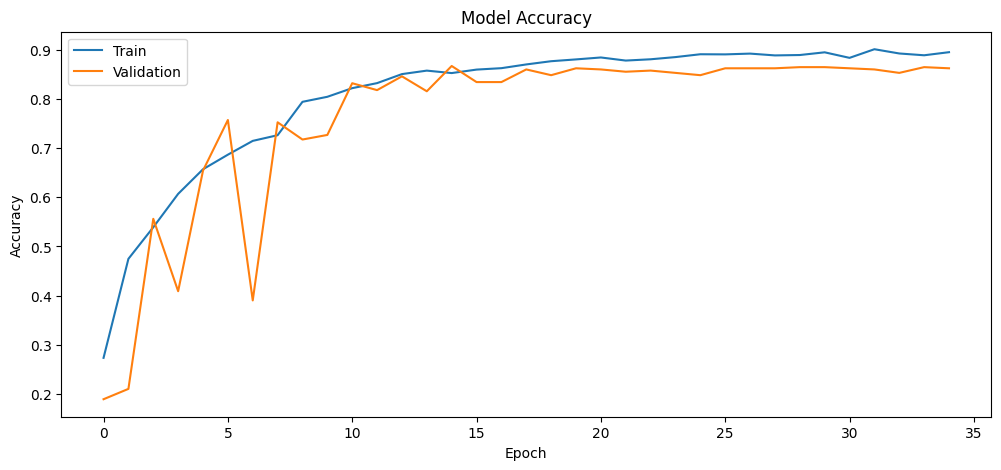

In [132]:
plt.plot(lron_da2_spe_es_history.history['accuracy'])
plt.plot(lron_da2_spe_es_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* From the graph we can see that the training accuracy and validation are reasonably close once epoch 18 is reached.
* this model has the closest trianing and validation we have seen so far.

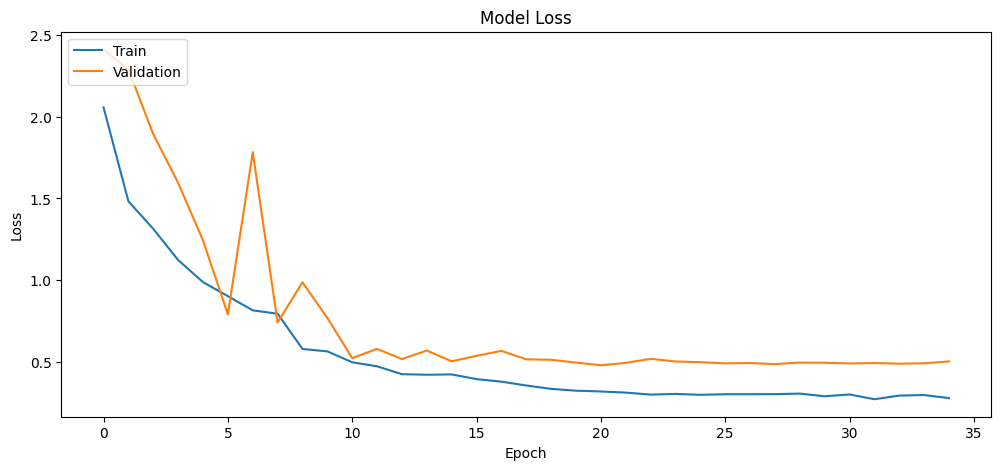

In [133]:
plt.plot(lron_da2_spe_es_history.history['loss'])
plt.plot(lron_da2_spe_es_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss flattens after epoch 15. I suspect if w elimited this model to 15 epochs we might se very close results.

**Evaluate the model on test data**

In [134]:
lron_da2_spe_es_accuracy = lron_da2_spe_es_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 47ms/step - loss: 0.5379 - accuracy: 0.8337


In [135]:
best_model_accuracy = lron_da2_spe_es_history.history['accuracy'][np.argmin(lron_da2_spe_es_history.history['loss'])]
best_model_accuracy

0.9009174108505249

In [136]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = lron_da2_spe_es_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.900917
Name: Complex Model with batch normalization, learning rate reduction, basic data augmentation, steps per epoch and early stopping, dtype: float64
accuracy    0.833684
Name: Complex Model with batch normalization, learning rate reduction, basic data augmentation, steps per epoch and early stopping, dtype: float64


#### Observations
* Test Accuracy is 83%
* Training model accuracy with least loss is 90%

**Plotting the Confusion Matrix**

In [137]:
# Complete the code to obtain the output probabilities
y_pred=lron_da2_spe_es_model.predict(X_test_normalized)    #<---- check this is right for others

15/15 [==============================] - 1s 50ms/step


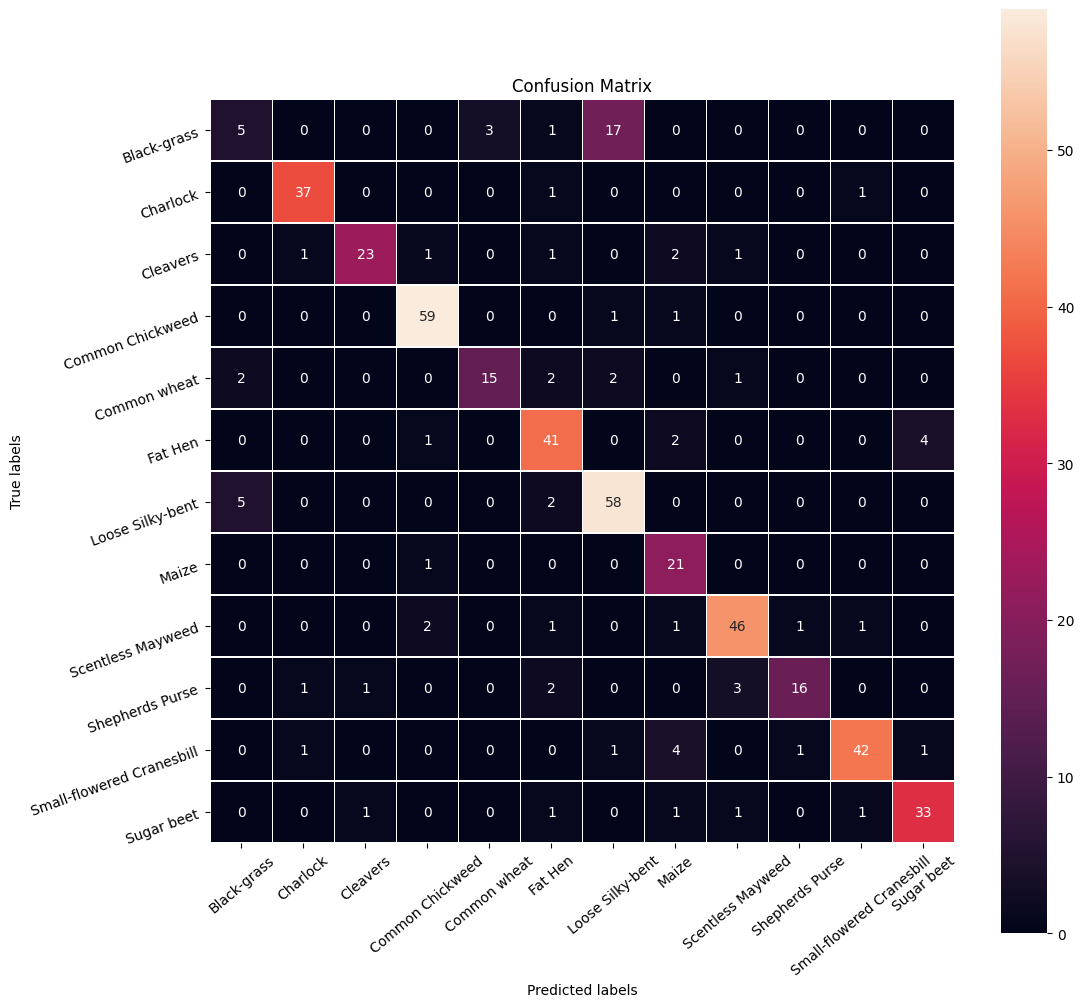

In [138]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Misclassification of Black-grass has worsened.
* Misclassification of Loose Silky-bent has improved.
* Most others have increased level of misclassification.

#### Add more complex data augmentaion to model
In this model we will try using more data augmentaion to improve the model. We will keep everything else the same.

In [139]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [140]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range = 0.2,
        fill_mode='nearest',
        rotation_range=180,  # randomly rotate images in the range (was 180)
        zoom_range = 0.2, # Randomly zoom image (was.1 with others)
        width_shift_range=0.2,  # randomly shift images horizontally
        height_shift_range=0.2,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )

In [141]:
early_stopping__callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, restore_best_weights=True)

In [142]:
model_name = "Complex Model with batch normalization, learning rate reduction, complex data augmentation, steps per epoch and early stopping"

In [143]:
h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# Intializing a sequential model
lron_da2_spe_model = Sequential()

# create convolution and max-pooling layers with input size of images
lron_da2_spe_model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(h,w,c)))
lron_da2_spe_model.add(BatchNormalization())
lron_da2_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da2_spe_model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
lron_da2_spe_model.add(BatchNormalization())
lron_da2_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da2_spe_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da2_spe_model.add(BatchNormalization())
lron_da2_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# create convolution and max-pooling layers
lron_da2_spe_model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
lron_da2_spe_model.add(BatchNormalization())
lron_da2_spe_model.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer
lron_da2_spe_model.add(Flatten())

# add a fully connected layer
lron_da2_spe_model.add(Dense(128, activation='relu'))
lron_da2_spe_model.add(Dropout(0.3))

# add a fully connected layer
lron_da2_spe_model.add(Dense(512, activation='relu'))
lron_da2_spe_model.add(Dropout(0.3))

# add a fully connected layer
lron_da2_spe_model.add(Dense(256, activation='relu'))
lron_da2_spe_model.add(Dropout(0.3))

# output layer with 12 neurons and softmax
lron_da2_spe_model.add(Dense(12, activation='softmax'))

# Adam Optimizer
opt=Adam()

# Compile the model
lron_da2_spe_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary
lron_da2_spe_model.summary()

width:   64
height:  64
channel: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                     

<b> Fitting the model on the train data

In [144]:
lron_da2_spe_history = lron_da2_spe_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=100,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size, #errors out of range
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction,early_stopping__callback])

Epoch 1/100
120/120 [==============================] - 18s 141ms/step - loss: 2.1294 - accuracy: 0.2634 - val_loss: 5.2550 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 19s 154ms/step - loss: 1.6919 - accuracy: 0.4204 - val_loss: 6.8600 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 18s 150ms/step - loss: 1.4913 - accuracy: 0.4750 - val_loss: 3.6939 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 18s 152ms/step - loss: 1.3416 - accuracy: 0.5394 - val_loss: 4.3308 - val_accuracy: 0.1449 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 18s 149ms/step - loss: 1.2554 - accuracy: 0.5740 - val_loss: 1.7323 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 18s 151ms/step - loss: 1.1122 - accuracy: 0.6176 - val_loss: 1.6744 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 7/100
120/120 [=========================

120/120 [==============================] - 18s 149ms/step - loss: 0.3206 - accuracy: 0.8760 - val_loss: 0.3026 - val_accuracy: 0.9206 - lr: 1.0000e-05
Epoch 45/100
120/120 [==============================] - 18s 153ms/step - loss: 0.3113 - accuracy: 0.8865 - val_loss: 0.3064 - val_accuracy: 0.9112 - lr: 1.0000e-05
Epoch 46/100
120/120 [==============================] - 19s 158ms/step - loss: 0.3138 - accuracy: 0.8875 - val_loss: 0.3136 - val_accuracy: 0.8972 - lr: 1.0000e-05
Epoch 47/100
120/120 [==============================] - 19s 157ms/step - loss: 0.3208 - accuracy: 0.8799 - val_loss: 0.3089 - val_accuracy: 0.8995 - lr: 1.0000e-05
Epoch 48/100
120/120 [==============================] - 18s 152ms/step - loss: 0.3110 - accuracy: 0.8855 - val_loss: 0.3066 - val_accuracy: 0.9112 - lr: 1.0000e-05
Epoch 49/100
120/120 [==============================] - 19s 157ms/step - loss: 0.3132 - accuracy: 0.8931 - val_loss: 0.3047 - val_accuracy: 0.9112 - lr: 1.0000e-05
Epoch 50/100
120/120 [=======

**Model Evaluation**

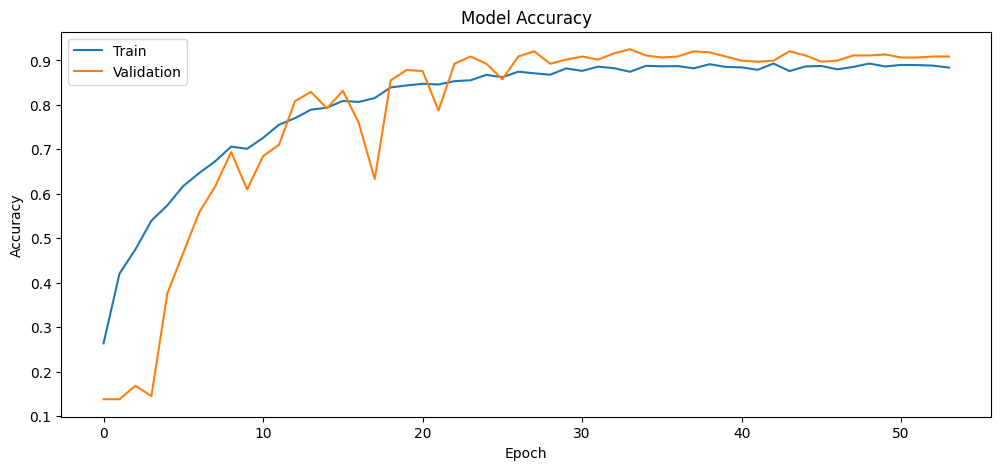

In [145]:
plt.plot(lron_da2_spe_history.history['accuracy'])
plt.plot(lron_da2_spe_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:

* From the graph we can see that the training and the validation accuracy was very close.
* Validation accuracy was higher than training in this model.

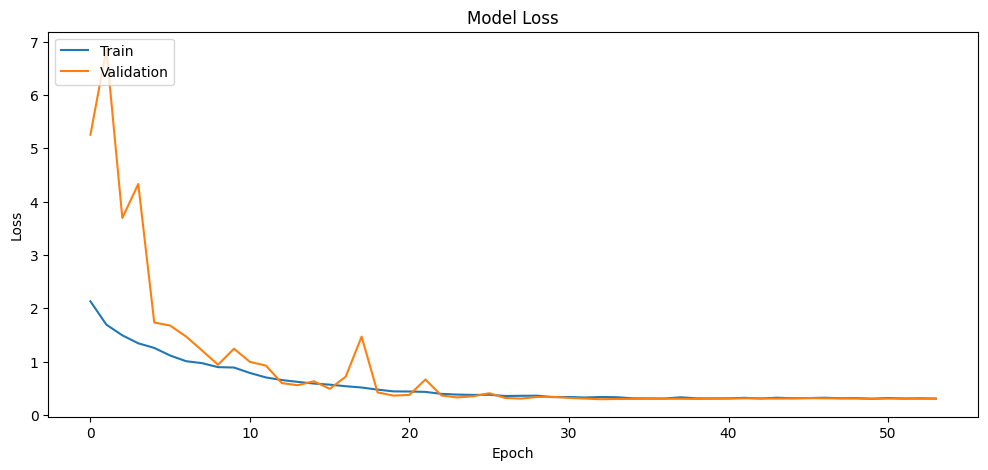

In [146]:
plt.plot(lron_da2_spe_history.history['loss'])
plt.plot(lron_da2_spe_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* Loss for training and accuracy were lockstep after epoch 22.

**Evaluate the model on test data**

In [147]:
lron_da2_spe_test_accuracy = lron_da2_spe_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 62ms/step - loss: 0.3626 - accuracy: 0.8758


In [148]:
best_model_accuracy = lron_da2_spe_history.history['accuracy'][np.argmin(lron_da2_spe_history.history['loss'])]
best_model_accuracy

0.8865006566047668

In [149]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = lron_da2_spe_test_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.886501
Name: Complex Model with batch normalization, learning rate reduction, complex data augmentation, steps per epoch and early stopping, dtype: float64
accuracy    0.875789
Name: Complex Model with batch normalization, learning rate reduction, complex data augmentation, steps per epoch and early stopping, dtype: float64


#### Observations
* Test Accuracy is 89%
* Training model accuracy with least loss is 88%
* This is our closest model thus far, but we do have models that have better accuracy.

**Plotting the Confusion Matrix**

In [150]:
# Complete the code to obtain the output probabilities
y_pred=lron_da2_spe_model.predict(X_test_normalized)

15/15 [==============================] - 1s 61ms/step


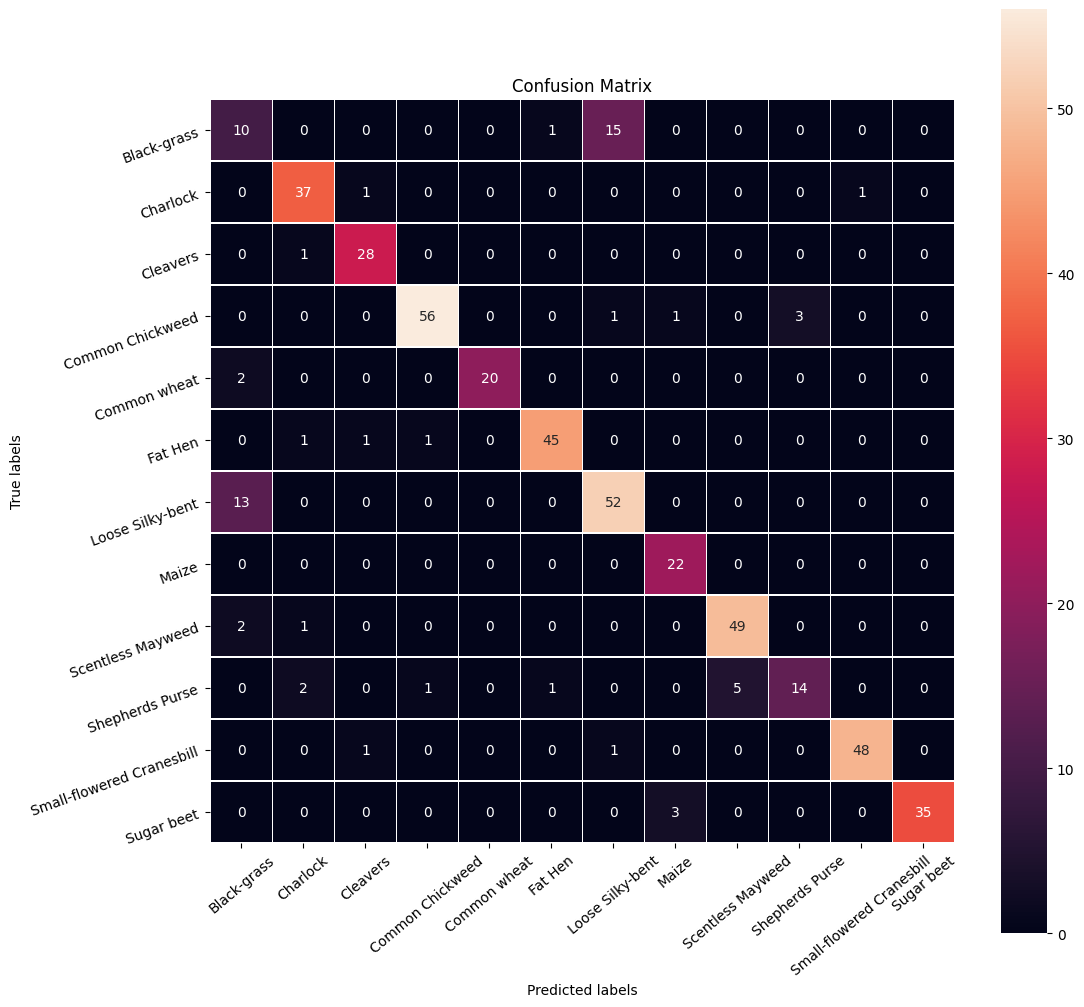

In [151]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* Misclassification of Black-grass and Loose Silky-bent has worsened
* Most others have varied improvement/worsening of misclassification.
* This model is still not suitable.

### Model using VGG16 pre-trained model
In this model we will use transfer learning from the VGG16 model to try and improve our classification. We will only take the bottom layers and of course make VGG16 non-trainable.  We will add our own dense layers.

In [152]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [153]:
model_name = "VGG16 Model"

In [154]:
early_stopping__callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=0.0001, restore_best_weights=True)

In [155]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)


vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (h,w,c))
vgg_model.summary()

width:   64
height:  64
channel: 3
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D

In [156]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [157]:
vgg_new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
vgg_new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
vgg_new_model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
vgg_new_model.add(Dense(128, activation='relu'))
vgg_new_model.add(Dropout(0.3))

# Adding a fully connected dense layer with 16 neurons
vgg_new_model.add(Dense(512, activation='relu'))
vgg_new_model.add(Dropout(0.3))

vgg_new_model.add(Dense(256, activation='relu'))
vgg_new_model.add(Dropout(0.3))

# output layer with 12 neurons 
vgg_new_model.add(Dense(12, activation='softmax'))

# initialize Adam Optimimzer
opt=Adam()
adam_opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile model
vgg_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
vgg_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [158]:
history_vgg16 = vgg_new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                                       epochs=100,
                                       steps_per_epoch=math.floor(X_train_normalized.shape[0] / batch_size), #error again
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction,early_stopping__callback])

Epoch 1/100
120/120 [==============================] - 24s 195ms/step - loss: 2.2127 - accuracy: 0.2173 - val_loss: 1.9076 - val_accuracy: 0.3294 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 23s 190ms/step - loss: 1.8482 - accuracy: 0.3394 - val_loss: 1.7546 - val_accuracy: 0.3785 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 23s 191ms/step - loss: 1.7462 - accuracy: 0.3641 - val_loss: 1.6430 - val_accuracy: 0.3925 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 23s 191ms/step - loss: 1.6884 - accuracy: 0.3872 - val_loss: 1.5719 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 22s 186ms/step - loss: 1.6371 - accuracy: 0.4128 - val_loss: 1.5323 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 23s 196ms/step - loss: 1.6326 - accuracy: 0.4121 - val_loss: 1.5059 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 7/100
120/120 [=========================

**Model Evaluation**

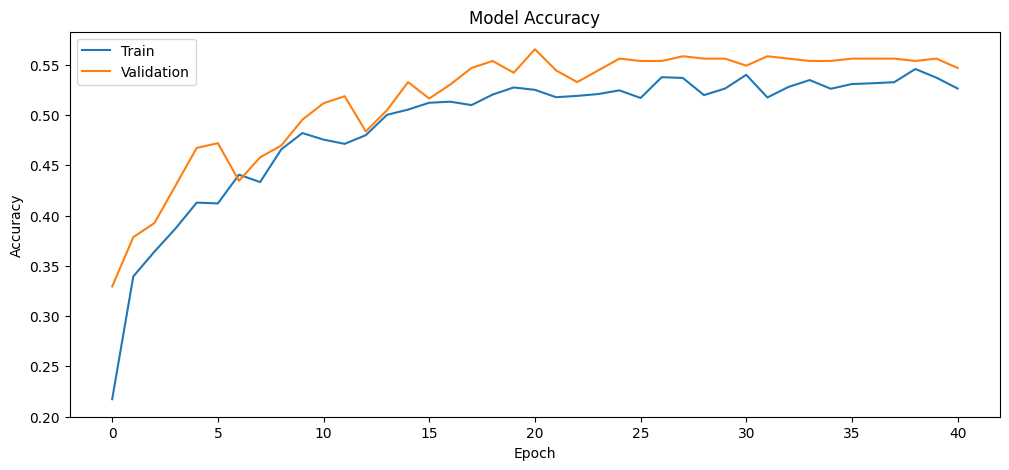

In [159]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* This model never achieves even 60% accuracy, and thus is a poor model compared to the other ones we have.

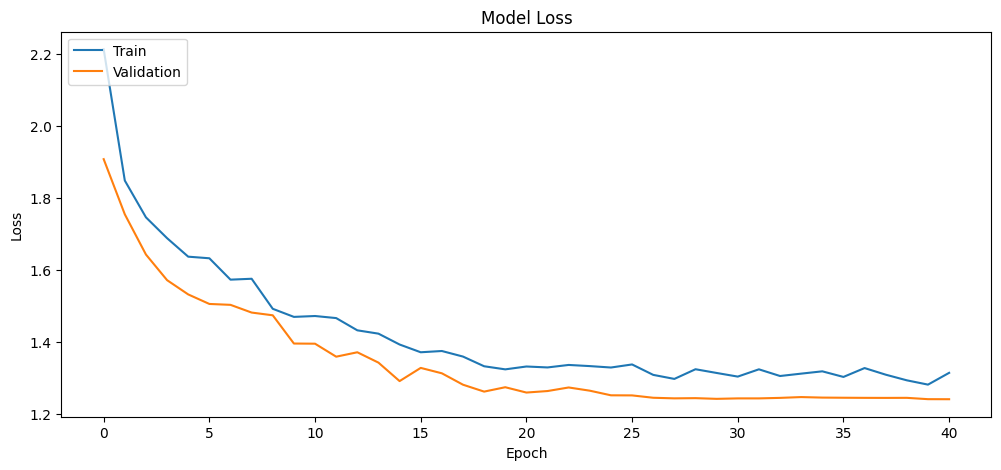

In [160]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [161]:
vgg_accuracy = vgg_new_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 3s 175ms/step - loss: 1.2491 - accuracy: 0.5642


In [162]:
best_model_accuracy = history_vgg16.history['accuracy'][np.argmin(history_vgg16.history['loss'])]
best_model_accuracy

0.5370904207229614

In [163]:
#Save metrics for later comparison
training_metrics.loc[model_name] = best_model_accuracy
test_metrics.loc[model_name] = vgg_accuracy[1]

print(training_metrics.loc[model_name])
print(test_metrics.loc[model_name])

accuracy    0.53709
Name: VGG16 Model, dtype: float64
accuracy    0.564211
Name: VGG16 Model, dtype: float64


#### Observations
* Test Accuracy is 56%
* Training model accuracy with least loss is 54%
* This model performed poorly, it may be too generalized

**Plotting the Confusion Matrix**

In [164]:
# Complete the code to obtain the output probabilities
y_pred=vgg_new_model.predict(X_test_normalized)

15/15 [==============================] - 3s 173ms/step


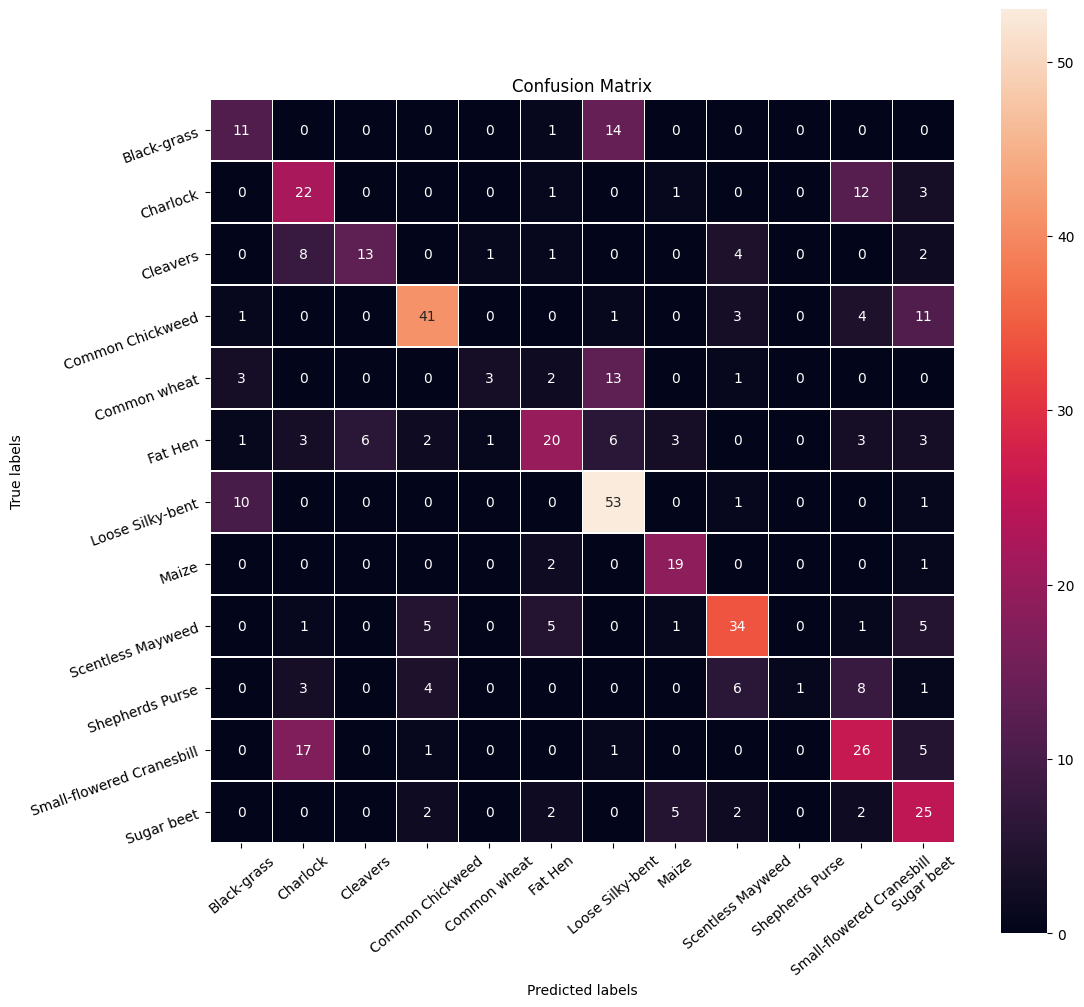

In [165]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

#### Observations
* This model did not perform well at all, Misclassification of many plants that were even bettwr identified with our basic model.  This model may be too generalized or the dense layers are poor.

In [166]:
training_metrics

accuracy
Base Model                                          0.700026
Complex Model                                       0.971146
Complex Model with Class Weights applied            0.939173
Complex Model with Adam optimizer adjusted          0.949051
Complex Model with learning rate reduction and ...  0.985703
Complex Model with batch normalization, learnin...  0.966467
Complex Model with batch normalization, learnin...  0.944692
Complex Model with batch normalization, learnin...  0.900917
Complex Model with batch normalization, learnin...  0.886501
VGG16 Model                                         0.537090

In [167]:
test_metrics

accuracy
Base Model                                          0.732632
Complex Model                                       0.821053
Complex Model with Class Weights applied            0.795789
Complex Model with Adam optimizer adjusted          0.840000
Complex Model with learning rate reduction and ...  0.911579
Complex Model with batch normalization, learnin...  0.894737
Complex Model with batch normalization, learnin...  0.896842
Complex Model with batch normalization, learnin...  0.833684
Complex Model with batch normalization, learnin...  0.875789
VGG16 Model                                         0.564211

## Final Model

While the "Complex Model with batch normalization, learning rate reduction, complex data augmentation, steps per epoch and early stopping" was very close on the training and test scorres, for this exercise we want the highest accuracy.  that came from model "Complex Model with learning rate reduction and batch normalization" with a 91% accuracy on test data.  This will be our final model.

In [168]:
lron_base_model_test_accuracy = lron_base_model.evaluate(X_test_normalized, 
                                                          y_test_encoded, 
                                                          #verbose=2
                                                         )

15/15 [==============================] - 1s 71ms/step - loss: 0.4490 - accuracy: 0.9116


In [169]:
best_model_accuracy = lron_base_history.history['accuracy'][np.argmin(lron_base_history.history['loss'])]
best_model_accuracy

0.98570317029953

#### Observations
* Test Accuracy is 91%
* Training model accuracy with least loss is 99%.

**Plotting the Confusion Matrix**

In [170]:
# Complete the code to obtain the output probabilities
y_pred=lron_base_model.predict(X_test_normalized)

15/15 [==============================] - 1s 71ms/step


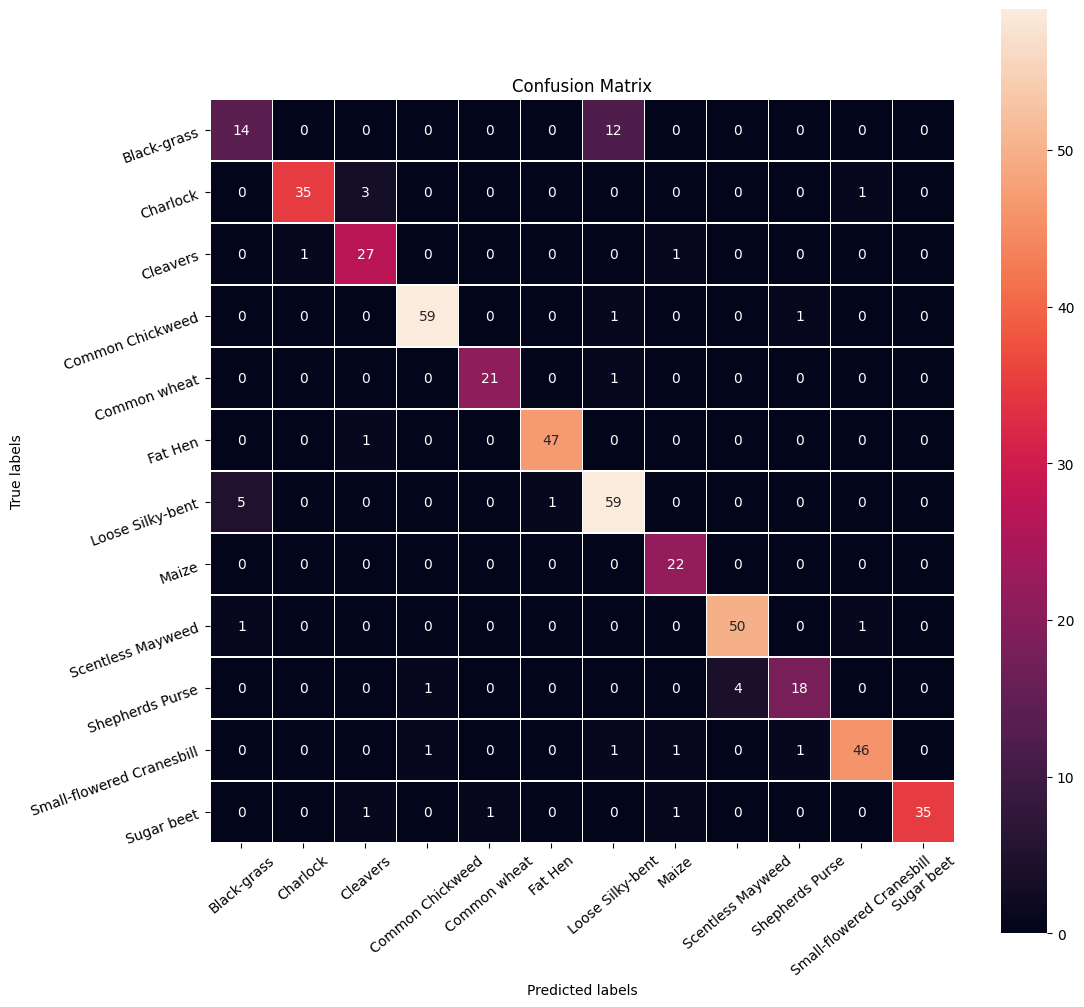

In [171]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

### Visualizing the prediction

width:   64
height:  64
channel: 3


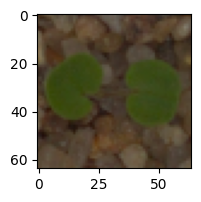

1/1 [==============================] - 0s 37ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


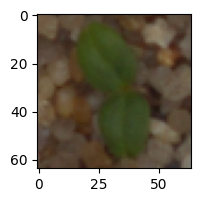

1/1 [==============================] - 0s 34ms/step
Predicted Label ['Cleavers']
True Label Cleavers


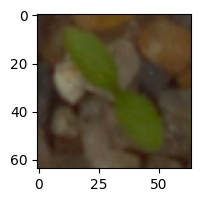

1/1 [==============================] - 0s 33ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


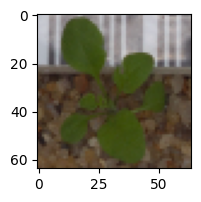

1/1 [==============================] - 0s 24ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [174]:
#lron_da_model until I have another model

h, w, c = X_train_normalized[1000].shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)


# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(lron_base_model.predict((X_test_normalized[2].reshape(1,h,w,c)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(lron_base_model.predict((X_test_normalized[33].reshape(1,h,w,c)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(lron_base_model.predict((X_test_normalized[59].reshape(1,h,w,c)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(lron_base_model.predict((X_test_normalized[36].reshape(1,h,w,c)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

In [173]:
# Plotting the classification report
cr=classification_report(y_test_arg,y_pred_arg,target_names=labels_plants)
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.70      0.54      0.61        26
                 Charlock       0.97      0.90      0.93        39
                 Cleavers       0.84      0.93      0.89        29
         Common Chickweed       0.97      0.97      0.97        61
             Common wheat       0.95      0.95      0.95        22
                  Fat Hen       0.98      0.98      0.98        48
         Loose Silky-bent       0.80      0.91      0.85        65
                    Maize       0.88      1.00      0.94        22
        Scentless Mayweed       0.93      0.96      0.94        52
          Shepherds Purse       0.90      0.78      0.84        23
Small-flowered Cranesbill       0.96      0.92      0.94        50
               Sugar beet       1.00      0.92      0.96        38

                 accuracy                           0.91       475
                macro avg       0.91      0.90      0.90    

#### Insights: 

This model does a good job of classifying these plants, for the most part. Several of the models had difficulty with Black-grass and Loose Silky-bent, but this model seems to mostly have difficulty with the Black-grass. Precision is above 90% for many plants, meaning that for those plants we are very accurate.

Having more samples of the lower represented plant classes would likely help with improving classification, as would further epochs , though from experimentation, not by a lot. In other models not included here, it was seen that not resizing images also helps with identification, however, this takes a lot longer to train the models so the loss we get by reducing image size may offset that.

Overall, a 91% accuracy rating feels like a good result, and a suitable model for use.